# Bayesian Machine Learning

## Fixed Basis Regression

#### Andrei-Ioan Bleahu, April 4 2025

## Generate Data

Let's consider an unknwon signal for a supervised problem:

- The labels are : $$ \textbf{y(x)} \in \Re $$
- The data (observations) are : $$ \textbf{x} \in \Omega \subset \Re^{N} $$

Let us generate a univariate hidden signal (this is our true signal):

$$ 
y(x) = k  \exp{(\frac{kx}{10})} \sin{(k x + 0.5)} \tag{1}
$$

In [2]:
using Distributions
using Plots
using Random 
using LinearAlgebra

In [3]:
function hidden_signal(x, k = 1.5)
    return k * exp(k * x * 0.1) * sin(k * x + 0.5)
end

hidden_signal (generic function with 2 methods)

Let's generate traning and testing data with some noise

In [4]:
function generate_train_test(size, noise_scale, ntrain)
    """
    Generates synthethic data with given noise_scale
    and splits it into training and test data.

    Args

    size : size of data
    noise_scale : noise variance
    ntrain : number of training samples
    """

    Random.seed!(2345)
    xs = shuffle(range(-10, 10, size))
    ys = hidden_signal.(xs) + randn(length(xs)) * noise_scale

    xtrain = xs[1:ntrain]
    ytrain = ys[1: ntrain]

    xtest = xs[(ntrain+1): end]
    ytest = ys[(ntrain+1): end]

    return xtrain, ytrain, xtest, ytest

end 

generate_train_test (generic function with 1 method)

In [5]:
xtrain, ytrain, xtest, ytest = generate_train_test(500, 0.4, 20)

([6.513026052104208, -0.10020040080160321, 9.839679358717435, 8.597194388777556, 0.06012024048096192, 7.394789579158316, 8.837675350701403, -2.024048096192385, -8.637274549098196, -8.837675350701403, -10.0, -2.2645290581162323, 3.6673346693386772, 4.348697394789579, -0.3406813627254509, 2.8657314629258517, 6.3927855711422845, 0.9418837675350702, 9.03807615230461, -1.8637274549098197], [-2.8338817414956607, 0.9174846717407883, 3.339198275120964, 3.5778032965752207, 0.2965774592354301, -3.9079650797072385, 5.711408514506781, -0.5394070421142815, -0.2516364754050313, 0.1967877851198152, -0.09729722951737074, -0.4021635486175258, -0.6754803022502249, 1.3120385419699652, -0.07851914784051525, -2.3757306379950838, -2.077343922549251, 1.6353636373597187, 5.8123389759094986, -1.6140507987231634], [6.312625250501002, -1.7434869739478958, -5.110220440881764, 2.224448897795591, 8.11623246492986, -4.789579158316633, -3.1062124248496996, -8.75751503006012, 4.028056112224449, 3.186372745490982  …  -

Let's plot the signal and the training data.

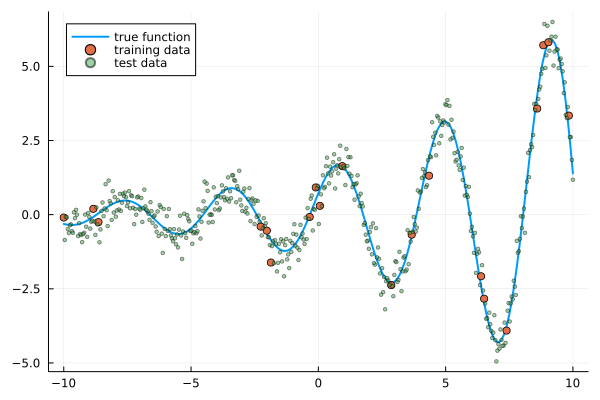

In [6]:
begin
	plot(-10:0.1:10, hidden_signal, lw=2, label="true function")
	plot!(xtrain, ytrain, st=:scatter, ms=4, label="training data")

	plot!(xtest, ytest, st=:scatter, ms=2, label="test data", alpha=0.5)
end

# 1. MLE

We can model the signal as a linear combination of $M$ basis functions $\phi_m(\mathbf{x})$ :

$$ {\bf y(x)_{true}} = \sum_{m=1}^{M} w_m \phi_m(\mathbf{x}) \tag{2} $$

In the above $ {\bf w} = (w_1, \cdots, w_m)^T$ are the weights of the linear combination. 


We can define the design matrix :


$$ \mathbf{\Phi} = (\phi_1, \cdots, \phi_m)$$

With 

$$\phi_m = (\phi_m(\mathbf{x_1}), \cdots, \phi_m(\mathbf{x_N}))^T$$

Hence observation are modelled like :

$$ \bf y = \mathbf{\Phi} \mathbf{w}  + \mathbf{\epsilon} \tag{3} $$

We are considering that our true signal has some noise, which is modelled via $\mathbf{\epsilon}$

$$ \bf y(x)_{true} = \mathbf{\Phi} \mathbf{w} $$

This is actually an interesting formulation, since we now consider a linear combination of non-linear (but fixed) functions $\phi_m$. So the assumption that our function must be linear (as in linear regression) is no longer necessary. 


Our data is a series of inputs $\mathbf{X} = {\mathbf{x_1}, \cdots, \mathbf{x_n}}$ with corresponding target variables ${y_1, \cdots, y_n}$. We make the assumption that our data is drawn from Gaussian distributions, and that they are independent (each observed variable is independent of another). Then we can express the likelihood of the observations $\mathbf{y}$ as as a product of probability distributions for the individual observations $y_i$:




$$
p(\mathbf{y} \vert \mathbf{w}, \sigma^{2}) = \prod_{i=1}^{n}  p(y^{(i)} \vert (\mathbf{\Phi} \mathbf{w})^{(i)}, \sigma^{2}) \tag{4}
$$

We recognize the term under the exponential as the sum of squared errors. From each observation $y_i$ we extract the $i$ th row of the $\bf \Phi w$ vector. Taking the logarithm yields :

$$
\ln p(\mathbf{y} \vert \mathbf{w}, \sigma^{2}) = \sum_{i=1}^{n} \ln p(y^{(i)} \vert (\mathbf{\Phi} \mathbf{w})^{(i)}, \sigma^{2}) \tag{5}
$$

Now, since I assume out data to be drawn from a Gaussian, the likelihood of $\bf y$ (the targets) given the data and noise variance is a Gaussian, as I established above. So this can be written analytically :

$$ 
\ln p(\mathbf{y} \vert \mathbf{w}, \sigma^{2}) = \sum_{i=1}^{n} \ln \frac{1}{\sqrt{2 \pi \sigma^2}} \exp{ - \frac{1}{2} (\frac{(y^{(i)} - (\mathbf{\Phi} \mathbf{w})^{(i)})}{\sigma})^{2}} \tag{6}
$$

Under the logarithm, the product becomes a sum and it follows :

$$ 
\ln p(\mathbf{y} \vert \mathbf{w}, \sigma^{2}) = - \frac{n}{2} \ln{(2 \pi \sigma^{2})} - \frac{1}{2 \sigma^{2}} \sum_{i=1}^{n} (y^{(i)} - (\mathbf{\Phi} \mathbf{w})^{(i)})^2 \tag{7}
$$

We could also express the above in terms of the precision $ \beta = \frac{1}{\sigma^{2}}$ :

$$ 
\ln p(\mathbf{y} \vert \mathbf{w}, \beta) = - \frac{n}{2} \ln{(\frac{2 \pi}{\beta})} - \frac{\beta}{2} \sum_{i=1}^{n} (y^{(i)} - (\mathbf{\Phi} \mathbf{w})^{(i)})^2 \tag{8}
$$


### $w_{MLE}$

In MLE we directly maximize the likelihood. Looking at $(8)$, this means that we maximize the begative of the sum of least squares. So, the objective is minimizing the sum of least squared, since this is equivalent to maximizing the log-likelihood (which is also the same as maximizing the likelihood!).

The sum of least squares must be minimized (which is the same as maximising the log of the likelihood) This is just the squared Euclidean norm i.e $\vert \vert \mathbf{r} \vert \vert ^2 = \mathbf{r}^T \mathbf{r}$. Hence:

$$
E_{LS}(\mathbf{w}) = ||\mathbf{y} - \mathbf{\Phi} \mathbf{w}||^{2} \tag{9}
$$

This is equivalent to the least squares estimate. Let's take the differential with respect to $\mathbf{w}$ :


$$
\frac{\delta E_{LS}(\mathbf{w})}{\delta \mathbf{w}} = - 2 ||\mathbf{y} - \mathbf{\Phi} \mathbf{w}|| \mathbf{\Phi}^T \tag{10}
$$

Equating this to zero and solving for $\mathbf{w}$ yields :

$$
\mathbf{w}_{MLE} = (\mathbf{\Phi}^T \mathbf{\Phi})^{-1} \mathbf{\Phi}^T \mathbf{y} \tag{11}
$$

### $\sigma_{MLE}$

Now, to find the optimal noise variance, let us take the derivative with respect to $\sigma^2$ (which is a scalar) :

$$
\nabla_{\sigma^2} \ln{p(\mathbf{y} \vert \mathbf{w}, \sigma^2)} = - \frac{n}{2} \frac{1}{2 \pi \sigma^2} 2 \pi + \frac{1}{2} \frac{1}{\sigma^4} \sum_{i=1}^{n} (y^{(i)} - (\mathbf{\Phi} \mathbf{w})^{(i)})^2 \tag{12}
$$

Equating the above to 0 and solving for $\sigma^2$ yields:

$$ 
\sigma^{2}_{MLE} = \frac{1}{n} \sum_{i=1}^{n} (y^{(i)} - (\mathbf{\Phi} \mathbf{w})^{i})^2 \tag{13}
$$

Which in vectorized form is

$$
\sigma^{2}_{MLE} = \frac{1}{n}  (\mathbf{y} - \mathbf{\Phi} \mathbf{w})^T (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) \tag{14}
$$

### Implementation

Let's consider radian basis functions. These functions should dependent on location $\mu$ :


$$
\phi(\mathbf{x}; \mu, \sigma^2) = \exp{ \{ - (\frac{1}{2 \sigma^2} (\mathbf{x - \mu})^{2}) \} } \tag{15}
$$

Clearly $\phi(x; \mu)$ are functions that depend on the parameters  $\mu$ and $\sigma^2$. 

In [7]:
function phi_rbf(x; μ = 0.0, σ = 1.0)
    """
    Used to create an RBF function
    for one data point or a vector of observations

        - x : data point or vector
        - μ : scalar
    """
    @. exp(-0.5 * (x - μ)^2 / σ^2)
end

phi_rbf (generic function with 1 method)

In [8]:
phi_rbf(3.14) # test output of one data

0.0072279487265724356

In [9]:
begin
    test_vect = [1, 3.4, 5.6]

    out_phi = phi_rbf(test_vect)

    println("Output of `phi_rbf` on vector",out_phi )
end

Output of `phi_rbf` on vector[0.6065306597126334, 0.0030887154082367718, 1.5497531357028994e-7]


We can implement a function to introduce the design matrix 

In [10]:
begin
	function basis_expand(xs, μs; σ = 0.5, include_bias = true)

		"""
		Builds design matrix based on :
		
		- locations μs
		- vectors of observations xs
		"""
		nobs = length(xs)
		nbasis = length(μs)
		Φ = zeros(nobs, nbasis)
		for (j, μ) in enumerate(μs)
			Φ[:, j] = phi_rbf(xs; μ = μ, σ = σ)
		end
		include_bias ? [ones(nobs) Φ] : Φ
		return Φ
	end
end

basis_expand (generic function with 1 method)

We'll set the number of bases to be the training data. 

In [11]:
begin 
    μs_centers = copy(xtrain) # the centres are just the training data
    σ_scale = 1.0
    Φ_train = basis_expand(xtrain, μs_centers; σ = σ_scale) # design matrix for training data 
    Φ_test = basis_expand(xtest, μs_centers; σ = σ_scale ) # design matrix for test data
end 

480×20 Matrix{Float64}:
 0.98012      1.1748e-9    0.00198914   …  0.0243788    3.04166e-15
 1.57424e-15  0.25919      7.33518e-30     5.73255e-26  0.992797
 4.60721e-30  3.54437e-6   2.93562e-49     3.4096e-44   0.00514434
 0.00010145   0.0670714    2.5542e-13      8.29521e-11  0.000234843
 0.276613     2.18998e-15  0.226472        0.653837     2.35625e-22
 1.81837e-28  1.67831e-5   3.36658e-47  …  3.0239e-42   0.0138385
 8.08017e-21  0.0109102    4.04544e-37     9.42566e-33  0.462141
 2.30972e-51  5.30897e-17  7.91411e-76     1.71059e-69  4.78881e-11
 0.0456141    0.00019919   4.63297e-8      3.54437e-6   2.8983e-8
 0.00395288   0.00451305   2.44149e-10     3.66733e-8   2.89723e-6
 3.24254e-9   0.937011     1.18716e-20  …  1.86118e-17  0.104746
 6.4272e-6    0.226472     2.18998e-15     1.15162e-12  0.00228934
 1.55667e-26  0.00010145   1.09336e-44     7.12211e-40  0.0412568
 ⋮                                      ⋱               
 1.46988e-35  1.1126e-8    2.92411e-56     7.83034e-5

In [12]:
function estimate_weights(phi, targets)
    return  phi \  targets
end

estimate_weights (generic function with 1 method)

In [13]:
w_mle = estimate_weights(Φ_train, ytrain)

20-element Vector{Float64}:
 -1419.468672792691
 10240.664764966312
   280.9898026865859
 -3875.893237784214
 -6615.66817820481
   469.3060190510168
  7985.79620000131
 -1953.2579189675957
   -18.984951874967763
    20.291229830298025
    -2.921800007572601
   515.9811314086406
   107.32084038405084
   -74.66684178383662
 -4104.029223708191
   -81.98204499811712
  1207.6791884036868
   339.5196347707568
 -4607.665981752135
  1607.6040692020522

We know built the same design matrix $\Phi$ for the test set and we use the previously estimated weights. 

In [14]:
function predict(w, Φ_test)
    return Φ_test * w
end

predict (generic function with 1 method)

In [15]:
ypred_mle = predict(w_mle, Φ_test)

480-element Vector{Float64}:
 -1.3769918797602885
 -2.8618502096475336
  0.5357914386547561
 10.778833436021706
 -3.015867608445583
  0.7858442063736726
 -4.379263438021941
  0.02765085297306931
  0.5957408565983923
 -3.2662951319203173
 -1.2975936135556763
 16.97163782146333
  0.6848189600871829
  ⋮
 -0.2730530430461062
  0.8292769733011058
 -6.963719152537022
  8.756502392558524
 -4.748964877164466
 15.773196284250165
 -3.327216850808765
 -1.9946723183273598
 -0.1791122239682154
 -0.394174752134064
 -0.8937812377527043
  1.9818707571637402

In [16]:
begin 
    function plot_evaluate_results(ypredictions)
        """
        Plots the training and test data 
        against predictions
        """
        plot(xtest, ytest, seriestype = :scatter, label = "test samples", xlabel = "x", ylabel = "y", title = "Test data")
        plot!(xtrain, ytrain, seriestype = :scatter, label = "training samples", color = :black, xlabel = "x", ylabel = "y", title = "Test data")
        plot!(xtest, ypredictions, seriestype = :line, label = "prediction", color = :red)
    end
end 

plot_evaluate_results (generic function with 1 method)

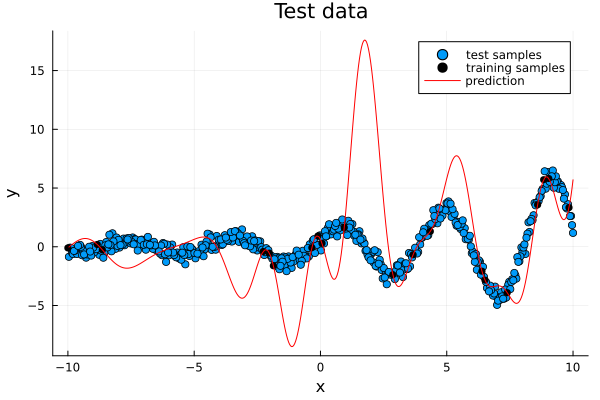

In [17]:
plot_evaluate_results(ypred_mle)

Let's calculate accuracy (train and test)

In [18]:
begin
    function mse(Φ, w, y)
        accuracy = (norm(Φ * w - y)^2) / length(y)
    end
end

mse (generic function with 1 method)

In [19]:
train_mse = mse(Φ_train, w_mle, ytrain)

3.719258158507785e-25

In [20]:
test_mse = mse(Φ_test, w_mle, ytest)

19.100290906310548

We also want to estimate the noise from the data (the squared variance)

In [21]:
begin 
    function estimate_noise(Φ, w, y)
        n = length(y)
        return (1 / n) * (y .- Φ * w)' * (y .- Φ * w)
    end
end

estimate_noise (generic function with 1 method)

In [22]:
σ²_mle = estimate_noise(Φ_train, w_mle, ytrain)

3.719258158507785e-25

Observe:

- Very small training error and large test error indicates overfitting
- Also the estimated noise from the training set is really small, which agains shows that our model is unrealistic.

# 2. MAP Estimation 

The essential difference  is that in MAP we optimize the posterior, not the likelihood ,and we make use of Bayes' rule to derive it from the likelihood .

Let's recall that the likelihood is :

$$
p(\mathbf{y} \vert  \mathbf{\Phi} \mathbf{w}, \sigma^{2}) \tag{16}
$$

Now, using Bayes' rule, we can get the posterior:

$$
p(\mathbf{w} |  \mathbf{y}) = \frac{ p(\mathbf{w}) p(\mathbf{y} \vert \mathbf{w}, \mathbf{\Phi}, \sigma^{2})}{p(\mathbf{y})} \tag{17}
$$

By estimating the posterior, we estimate the weights $\mathbf{w}$ and the variance of these weights $\sigma^2$ given the data $(\mathbf{y})$. 

We can take apply the logarithm on both sides :

$$
\ln{p(\mathbf{w} |  \mathbf{y})} = \ln{p(\mathbf{w})} +  \ln{p(\mathbf{y} \vert \mathbf{w}, \mathbf{\Phi}, \sigma^{2})}  - \ln{p(\mathbf{y})} \tag{18}
$$

The last term of equation;s $(18)$ RHS is the evidence term, a constant (does not depend on $\bf w$). 

Maximizing the posterior yields: 

$$
\arg \max_{w} \ln{p(\mathbf{w} |  \mathbf{y})} = \arg \max_{\mathbf{w}} (\ln{p(\mathbf{w})} +  \ln{p(\mathbf{y} \vert \mathbf{w}, \mathbf{\Phi}, \sigma^{2})}) \tag{19}
$$

Recalling equation $(7)$ :

$$ 
\arg \max_{w} \ln{p(\mathbf{w} |  \mathbf{y})} = \arg \max_{\mathbf{w}} (\ln{p(\mathbf{w})}   - \frac{1}{2 \sigma^{2}} \sum_{i=1}^{n} (y^{(i)} - (\mathbf{\Phi} \mathbf{w})^{(i)})^2) \tag{20}
$$

So this is simply the MAP estimate :

$$
\mathbf{w}_{MAP} \leftarrow \arg \max_{\mathbf{w}} (\ln{p(\mathbf{w})}  - \frac{1}{2 \sigma^{2}} \sum_{i=1}^{n} (y^{(i)} - (\mathbf{\Phi} \mathbf{w})^{(i)})^2) 
$$


But to solve this we have to assume the form of the prior, $p(\mathbf{w})$ !

We assume $\mathbf{w}$ consists of zero-mean, m-dimensional independent Gaussians. This means that we believe weights to be small (close to 0) and we are interested in finding a variance around these weights. So we do not assume that any of the weights is large. There is another reason for this assumption. When optimzing the posterior, we are interested in the prior of $\mathbf{w}$ and the likelihood. If both are Gaussians, the posterior is also a Gaussian (they are conjugate). Then :

$$
p(\mathbf{w}) = \prod_{j=1}^{m} N(w_j ; 0, \frac{1}{\lambda^2}) \tag{21}
$$

Since each Gaussian can be expressed analytically and each $w_j$ is independent :

$$
p(\mathbf{w}) = (\frac{1}{\sqrt{2 \pi (\frac{1}{\lambda})^{2}}})^{m} \exp{ \{ -\frac{\lambda^2}{2} \sum_{j=1}^{m} w_j^2 \}} \tag{22}
$$

Which means :

$$
p(\mathbf{w}) = (\frac{\lambda}{\sqrt{2 \pi }})^{m} \exp{ \{ -\frac{\lambda^2}{2} \sum_{j=1}^{m} w_j^2 \}} \tag{23}
$$

We can take the logarithm which gives :

$$ 
\ln{p(\mathbf{w})} = \text{const} - \frac{\lambda^2}{2} \sum_{j=1}^{m} w_j^2  \tag{24}
$$

Substituting $(24)$ into $(20)$ yields (ignoring the constant under the maximization):

$$
\mathbf{w}_{MAP} = \arg \max_{\mathbf{w}} (- \frac{\lambda^2}{2} \sum_{j=1}^{m} w_j^2  - \frac{1}{2 \sigma^{2}} \sum_{i=1}^{n} (y^{(i)} - (\mathbf{\Phi} \mathbf{w})^{(i)})^2) \tag{25}
$$

This is equivalent to minimizing the negative :

$$ 
\mathbf{w}_{MAP} = \arg \min_{\mathbf{w}}\frac{1}{2 \sigma^{2}}\sum_{i=1}^{n} (y^{(i)} - (\mathbf{\Phi} \mathbf{w})^{(i)})^2 + \frac{\lambda^2}{2} \sum_{j=1}^{m} w_j^2 \tag{26}
$$



By putting everything into vector form we can identify that this is simply Ridge regression:

$$
\mathbf{w}_{MAP} = \arg \min ( \frac{1}{2 \sigma^{2}} ( \mathbf{y} - \mathbf{\Phi} \mathbf{w})^T ( \mathbf{y} - \mathbf{\Phi} \mathbf{w}) + \frac{\lambda^2}{2} \mathbf{w}^T \mathbf{w} ) \tag{27}
$$

We can take the gradient with respect to $\mathbf{w}$ for the term on the RHS. The gradient of the ridge loss:

$$ 
\nabla_{\mathbf{w}} L_{MAP}= - \frac{1}{\sigma^{2}} \mathbf{\Phi}^T (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) + \lambda^2 \mathbf{w} 
$$


To find $w_{MAP}$, we set the gradient to 0 and solve for $w$ :



$$
\mathbf{w}_{MAP} = (\mathbf{\Phi}^{T} \mathbf{\Phi} + \sigma^2 \lambda^2 \mathbf{I})^{-1} \mathbf{\Phi}^T \mathbf{y} \tag{28}
$$

It is clear that by setting $\lambda^2$ to 0 we recover MLE

### Implementation

Let's implement a method for calculating the weights based on strength of regularization. We implement a function for equation $(28)$. In the implementation, we can simply consider the regularisation constant to include the noise, so we can get rid of $\sigma^2$ : 

$$
\mathbf{w}_{MAP} = (\mathbf{\Phi}^{T} \mathbf{\Phi} + \lambda^2 \mathbf{I})^{-1} \mathbf{\Phi}^T \mathbf{y} \tag{29}
$$

In [23]:
begin 
    function map_estimate(Φ, y; λ = 0.8)
        return inv(Φ'* Φ + λ^2 * I) * Φ' * y 
    end
end

map_estimate (generic function with 1 method)

Now, we have the same case as before but with regularisation. We are free to choose the constant ()

In [24]:
w_map = map_estimate(Φ_train, ytrain)

20-element Vector{Float64}:
 -1.0830719564242242
  0.1031093137056129
  1.2123729221934698
  1.1213429342159151
  0.2727901003988788
 -2.013864178085612
  1.6182044412419616
 -0.2995850901122577
 -0.013046885345789513
 -0.008755662363968875
 -0.03282669677338247
 -0.17830806730172533
 -0.2493489264140559
  1.0191566400904266
 -0.13766492673758285
 -1.3896680874394287
 -0.8080304690482397
  0.7818195800654378
  1.8382831793928647
 -0.378351515637739

In [25]:
ypred_map = predict(w_map, Φ_test)

480-element Vector{Float64}:
 -2.6548765952675915
 -0.7692202406784996
 -0.007651864534697065
 -0.7415735624836172
  1.6886108865595737
 -0.019148141534730614
 -0.4666361776262251
 -0.03685106257579839
 -0.07160583551744747
 -0.9675731752149158
  0.7527230673151236
  0.05399430946522914
 -0.05259330481198764
  ⋮
 -0.0010442196432444604
 -0.026353080981020977
 -0.16043931465681932
 -0.8275907205304305
  0.3115689096378367
 -0.4410929430190262
 -2.881805577957009
 -0.7926464749766738
 -0.0009304480562859512
 -0.8240303074990702
 -0.5177800415198328
  0.1590498677648915

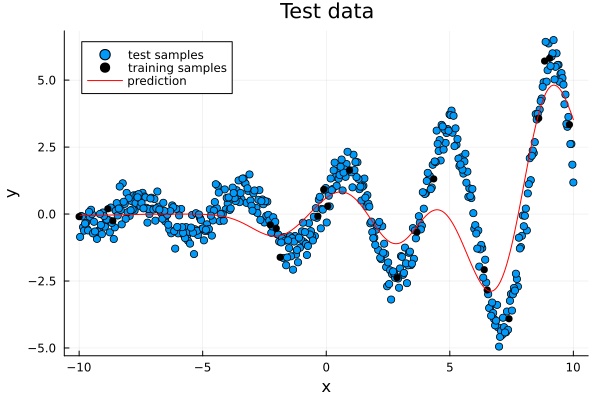

In [26]:
plot_evaluate_results(ypred_map)

Observe:

- We already have a much better fit, by simply adding regularization

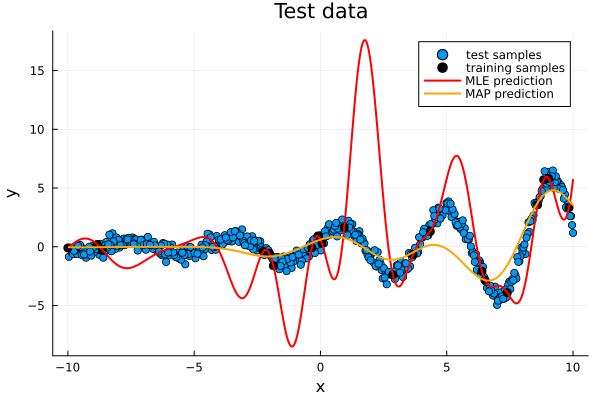

In [27]:
plot(xtest, ytest, seriestype = :scatter, label = "test samples", xlabel = "x", ylabel = "y", title = "Predictions")
plot!(xtrain, ytrain, seriestype = :scatter, label = "training samples", color = :black, ms= 5, xlabel = "x", ylabel = "y", title = "Test data")
plot!(xtest, ypred_mle, seriestype = :line, label = "MLE prediction", color = :red, lw = 2)
plot!(xtest, ypred_map, seriestype = :line, label = "MAP prediction", color = :orange, lw = 2)

In [28]:
map_train_mse = mse(Φ_train, w_map, ytrain)

0.7207910639609297

In [29]:
map_test_mse = mse(Φ_test, w_map, ytest)

1.5269310986508775

Let's look again at MLE test\train errors

In [30]:
mle_test_mse = mse(Φ_test, w_mle, ytest)

19.100290906310548

In [31]:
mle_train_mse = mse(Φ_train, w_mle, ytrain)

3.719258158507785e-25

Observe:

- Higher train MSE but much lower MSE on test set
- We can clearly see that regularisation is really helpful 

# 4. Gibbs Sampling 

## 4.0 General Treatment

Following is Based on [Barber](http://web4.cs.ucl.ac.uk/staff/D.Barber/textbook/090310.pdf), MLAPP Chapter 23.2 and and [Sampling Methods](https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture18.pdf) by Michael Jordan.

Assume we have a sample. This is a vector that contains a specific assignment of variables. Let's assume that in an iterative process, the sample at step $s$ is:

$
 \mathbf{x}^{s} = (x_1^s, x_2^s, \cdots, x_n^s)
 $. 



Our objective is to generate a new sample $\mathbf{x}^{(s+1)}$ based on the previous samples. We always update the new sample based on the previous sampled values. 

To illustrate how Gibbs Sampling works in practice, I will generate the first two steps of the process(sampling two variables) :

**Step 1**

$$
x_1^{(s+1)} \sim P(x_1 \vert  x_{2}^{(s)}, \cdots, x_n^{(s)}) \tag{30}
$$

**Step 2**

Notice that we now obtained $x_1^{(s+1)}$, so when we sample $x_2^{(s+1)}$ we have:

$$
x_2^{(s+1)} \sim P(x_2 \vert  x_{1}^{(s+1)}, \cdots, x_n^{(s)})
$$



The following is adapted from Steve Morse's [page](https://stmorse.github.io/journal/gibbs.html).

We have our data $y$ which is a set responses(targets) :

$$
\mathbf{y} = [y_1, y_2, \cdots, y_n]
$$

However, recalling $(3)$ the signal can be expressed in terms of the design matrix $\Phi$:

$$
\mathbf{y} = \mathbf{\Phi} \mathbf{w} + \epsilon
$$

We assume that both the weights and the noise are zero-mean Gaussian with different variances. 

$$
\mathbf{\epsilon} \sim N(0, \beta^{-1} \mathbf{I})

$$

In the above, we are assuming that each component of $\epsilon$ the noise vector $\mathbf{\epsilon}$ has the same global precision $\beta$. This assumption is tied to the noise being generated by the process itself (for example taking measurements, the noise is connected to how well the signal is preserved)

However, for the weights, we assume that each has its own precision. Essentially, we are saying that our weights have different degrees of confidence, becuase we do not expect all features to contribute equally to the signal. The noise, on the other hand, is something that is connected to the generating process itself. 

$$
w_m \sim N(0, \alpha_m^{-1})
$$

### Why Gaussians ?

- The noise represents fluctuations around the true signal, so we assume that that it is ideally centered on 0 (true signal)

- We choose a zero-mean Gaussian for the weights because we believe the weights are small (centered around 0) and their variance is controlled

Now, it seems that the important parameters are $\alpha_m$ (for each $w_m$), and $\beta$ for the noise. We would need some distributions to draw these from. 

### What to sample?

It seems there are three things to estimate:

1. The weights $\mathbf{w}$

2. The noise precision $\beta$

3. The vector of weight precisions $\mathbf{\alpha}$

Basically, we want to implement an iterative process that updates these three:

$$
(\mathbf{w}^s, \beta^s, \mathbf{\alpha}^s) \rightarrow (\mathbf{w}^{s+1}, \beta^{s+1}, \mathbf{\alpha}^{s+1})
$$

Gibbs sampling means:

1. 
$$
\mathbf{w}^{(s+1)} \sim p(\mathbf{w} \vert \mathbf{y}, \beta^s, \mathbf{\alpha}^s ) \tag{31}
$$

Now that we already sampled $\mathbf{w}^{(s+1)}$ : 

2.
$$
 \beta^{(s+1)} \sim p( \beta \vert \mathbf{y}, \mathbf{w}^{(s+1)}) \tag{32}
$$

And finally :

3.
$$
\mathbf{\alpha}^{(s+1)} \sim p(\mathbf{\alpha} \vert \mathbf{w}^{(s+1)}) \tag{33}
$$

## 4.1 Application

Let's now apply Gibbs sampling to our case. Key is that we need the posteriors to draw from. So let us calculate each of the posteriors.

### 1. $ p(\mathbf{w} \vert \mathbf{y}, \mathbf{\Phi}, \beta, \mathbf{\alpha} ) $

We can express the likelihood of the data given the parameters (equation $(4)$) in terms of the precision $\beta$ instead of $\sigma^2$ :


$$
p(\mathbf{y} \vert \mathbf{w}, \mathbf{\Phi},  \beta) = \prod_{i=1}^{n}  p(y^{(i)} \vert (\mathbf{\Phi} \mathbf{w})^{(i)}, \beta^{-1}) \tag{4}
$$


So essentially our result is :

$$
p(\mathbf{y} \vert \mathbf{w}, \mathbf{\Phi}, \beta) = N (\mathbf{y} ;\mathbf{\Phi} \mathbf{w}, \beta^{-1} \mathbf{I})
$$


We apply Bayes' rule to get the posterior: 

$$ 
p(\mathbf{w} \vert \mathbf{y}, \mathbf{\Phi}, \beta^{-1}, \mathbf{\alpha}) = \frac{ p(\mathbf{y} \vert \mathbf{w}, \mathbf{\Phi}, \beta^{-1})  p(\mathbf{w \vert \alpha}) }{p(\mathbf{y})} \tag{34}
$$

We are sampling the weights from a gaussian, so the prior is :

$$
p(\bf w \vert \mathbf{0}, \alpha) = N(\mathbf{w} ; 0, \mathbf{A}^{-1}) \tag{35}
$$

With 

$$ 
\mathbf{A} = diag(\alpha_1, \cdots, \alpha_m)  = diag(\mathbf{\alpha}) \tag{36}
$$

It is easy to show that since :

$$ \mathbf{A} = diag(...\alpha_m ...)$$

It's inverse is:

$$ \mathbf{A}^{-1} = diag(...\alpha_m^-1 ...)$$

Because:

$$ \mathbf{A} \mathbf{A}^{-1} =  \mathbf{I} $$

### Mean and Covariance of Posterior - Proof

Let us prove the mean and covariance of our Gaussian.

We start with the analytical forms. For the likelihood the analytical form is given by

$$
N(\mathbf{y} ;\mathbf{\Phi} \mathbf{w}, \beta^{-1} \mathbf{I}) = (\frac{1}{2 \pi})^{\frac{n}{2}} \frac{1}{\vert \beta \mathbf{I} \vert^{\frac{1}{2}}} \exp{ (-\frac{\beta}{2} (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) ^ T (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) ) } \tag{37}
$$

Similarly, for the prior of the weights :

$$ 
 N(\mathbf{w} ; 0, \mathbf{A}^{-1}) = (\frac{1}{2 \pi})^{\frac{n}{2}} \frac{1}{\vert  \mathbf{A} \vert^{\frac{1}{2}}} \exp{(- \frac{1}{2} \mathbf{w}^T \mathbf{A} \mathbf{w})} \tag{38}
$$

Now, the important factors are under the exponentials. Multiplying the two distributions means adding the terms under the exponentials. We are using:

$$ \exp{(a)} \exp{(b)} = \exp{(a +b)} $$

Now if we take the logarithm of the product on the RHS of equation $(34)$ while recalling that the evidence term is a constant we obtain :

$$
\ln p(\mathbf{y} \vert \mathbf{w}, \mathbf{\Phi}, \beta^{-1})  p(\mathbf{w \vert \alpha})  = -\frac{1}{2} [ \beta (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) ^ T (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) + \mathbf{w}^T \mathbf{A} \mathbf{w}] + \text{const} \tag{39}
$$

We can do multiply the brackets and re-arrange the terms on the RHS of $(39)$ and the LHS of $(39)$ is just the logarithm of the posterior and a constant (the logarithm of the evidence term) :

$$
\ln p(\mathbf{w} \vert \mathbf{y}, \mathbf{\Phi}, \beta^{-1}, \mathbf{\alpha}) = -\frac{1}{2} [ \mathbf{w}^T \beta \mathbf{\Phi}^T \mathbf{\Phi} \mathbf{w} + \mathbf{w}^T \mathbf{A} \mathbf{w} - 2 \beta \mathbf{y}^T \mathbf{\Phi}  \mathbf{w}] + \text{const} \tag{40}
$$

In the above we see that we can group the term under $\bf w^T w$ :


$$
\ln p(\mathbf{w} \vert \mathbf{y}, \mathbf{\Phi}, \beta^{-1}, \mathbf{\alpha}) = -\frac{1}{2} [ \mathbf{w}^T (\beta \mathbf{\Phi}^T \mathbf{\Phi} + A) \mathbf{w} - 2 \beta \mathbf{y}^T \mathbf{\Phi}  \mathbf{w}] + \text{const} \tag{41}
$$

Now, let us recall that for a Gaussian, we can complete the square such that :



$$
(\mathbf{w} - \mathbf{\mu}) ^ T \mathbf{\Sigma}^{-1} (\mathbf{w} - \mathbf{\mu}) = \mathbf{w}^T \mathbf{\Sigma^{-1}} \mathbf{w} - 2 \bf \mu^T \Sigma^{-1} w \tag{42}
$$


Because $\mathbf{\Sigma}$ is positive definite, which means:

$$
\mathbf{\Sigma}^T = \mathbf{\Sigma}
$$

Now, we can compare the Gaussian kernel in $(42)$ with $(41)$.

We can identify $\bf \Sigma$ by looking at the first term of the Kernel, the square term:

$$
\mathbf{\Sigma} = (\beta \mathbf{\Phi}^T \mathbf{\Phi} + \mathbf{A})^{-1} \tag{43}
$$

Similarly, we can compare the term that is multiplied to $\mathbf{w}$

$$
\mathbf{\mu^T \Sigma^{(-1)}} = \beta \bf y^T \Phi  \tag{44}
$$

Now, we can multiply both terms by $\bf \Sigma^{(-1)}$ on the right in equation $(44)$: 

$$
\mathbf{\mu^T \Sigma^{(-1)} \Sigma} = \beta \bf y^T \Phi \Sigma  \tag{45}
$$

Clearly multiplying a matrix by its inverse is simply the identity:

$$
\mathbf{\mu^T } = \beta \bf y^T \Phi \Sigma  \tag{46}
$$

From $(46)$ we can directly obtain $\bf \mu$

$$
\mathbf{\mu } = (\beta \bf y^T \Phi \Sigma)^T  \tag{47}
$$

Since $\beta$ is a scalar, its transpose is the same as itself.

$$
\mathbf{\mu } = \beta \bf \Sigma^T \Phi^T  y  \tag{48}
$$

But we know the covariance matrix is positive definite! This means it is equal to its transpose:

$$
\mathbf{\mu} = \beta \bf \Sigma \Phi^T  y  \tag{49}
$$

So we have obtained that the posterior distribution is a Gaussian with known mean and covariance:

$$
p(\mathbf{w} \vert \mathbf{y}, \mathbf{\Phi}, \beta^{-1}, \mathbf{\alpha}) = N (\mathbf{w}; \bf \mu, \Sigma)
$$

With the mean and covariance being given by equations $(43)$ and $(49)$ respectively:

$$
\mathbf{\Sigma} = (\beta \mathbf{\Phi}^T \mathbf{\Phi} + \mathbf{A})^{-1} \tag{43}
$$

$$
\mathbf{\mu} = \beta \bf \Sigma \Phi^T  y  \tag{49}
$$

### 2. $ p( \beta \vert \mathbf{y}, \mathbf{w}^{(s+1)}) $

Again using Bayes's rule :

$$ 
 p( \beta \vert \mathbf{y},  \mathbf{w})= \frac{ p(\mathbf{y} \vert \mathbf{w}, \mathbf{\Phi}, \beta)  p(\mathbf{\beta}) }{p(\mathbf{y})} \tag{50}
$$

As before our likelihood is a Gaussian : 

$$
p(\mathbf{y} \vert \mathbf{w}, \mathbf{\Phi}, \beta) = N (\mathbf{y} ;\mathbf{\Phi} \mathbf{w}, \beta \mathbf{I}) \tag{51}
$$

But now the problem is selecting a good prior $p(\beta)$. Let's have a look at a Gamma function

$$
p(\beta) = Gamma(\beta; c, d ) \tag{52}
$$

Analytically this is :


$$
p(\beta; c, d) = \frac{d^{c}}{\Gamma (c)} (\exp{(- d \beta)}) \beta^{(c-1)} \tag{53}
$$

Why do we choose a Gamma prior?

- Always positive : it is strictly positive, which is useful for restricting our noise to be positive
- Conjugate: when multiplied by the Gaussian (the likelihood) it also gives a Gamma distribution : this is because the term under the exponential of the Gaussian becomes incorporated in the exponential of the Gamma prior

So, our posterior is essentially also a Gamma function.


Recoginizing that the denominator of $(50)$ is a constant we can write:

$$
p( \beta \vert \mathbf{y}, \mathbf{w}) \propto d^{c} (\frac{1}{2 \pi})^{\frac{n}{2}} \frac{1}{\Tau(c)} \beta^{(c-1)}\frac{1}{\vert \beta \mathbf{I} \vert^{\frac{1}{2}}} \exp{( -\frac{\beta}{2} (\mathbf{y} - \mathbf{\Phi} \mathbf{w})^T (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) )} \exp{(-d \beta)} \tag{54}
$$

The term in front is just a constant, so : 

$$
p( \beta \vert \mathbf{y}, \mathbf{w}) \propto \beta^{(c-1)} \frac{1}{\vert \beta \mathbf{I} \vert^{\frac{1}{2}}} (\exp{( -\frac{\beta}{2} (\mathbf{y} - \mathbf{\Phi} \mathbf{w})^T (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) )}) \exp{(-d \beta)} \tag{55}
$$

Equation $(55)$ shows that the posterior of $\beta$ is clearly another Gamma function but with different constants. We can relate the constants of the new Gamma function to those of the prior.

We can also calculate the root of the determinant of the matrix. Clearly our matrix is diagonal :

$$
\frac{1}{\vert \beta \mathbf{I} \vert^{\frac{1}{2}}} = \beta^{-\frac{n}{2}} \tag{56}
$$

So when we multiply with $\beta^{(c-1)}$ we get $\beta^{(c-1 + \frac{n}{2})}$. This means :

$$
\tilde{c} = c + \frac{n}{2} \tag{57}
$$

We can see that the terms under the exponentials can be summed, and we can factor $\beta$. This is equivalent to :


$$ \tilde{d} = d + \frac{1}{2}  (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) ^ T (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) \tag{58}

So, our posterior then becomes :

$$
p( \beta \vert \mathbf{y}, \mathbf{w}) = Gamma(\beta; \tilde{c}, \tilde{d}) \tag{59}
$$

### 3. $ p(\mathbf{\alpha} \vert \mathbf{w}) $

The likelihood of the weights given $\mathbf{\alpha}$ :

$$
p(\bf w \vert \mathbf{0}, \alpha) = N(\mathbf{w} ; 0, \mathbf{A}^{-1}) \tag{60}
$$


We can apply Bayes' rule :

$$ 
p(\mathbf{\alpha} \vert \mathbf{w}) = \frac{p(\mathbf{w} \vert \mathbf{\alpha}) p(\mathbf{\alpha})}{p(\mathbf{w})} \tag{61}
$$

The analytical expression of the likelihood is :

$$ 
 N(\mathbf{w} ; 0, \mathbf{A}^{-1}) = (\frac{1}{2 \pi})^{\frac{n}{2}} \frac{1}{\vert  \mathbf{A}^{-1} \vert^{\frac{1}{2}}} \exp{- \{ \frac{1}{2} \mathbf{w}^T \mathbf{A} \mathbf{w} \} } \tag{62}
$$

But we can also express this as a product:

$$ 
 N(\mathbf{w} ; 0, \mathbf{A}^{-1}) = \prod_{j=1}^{n} (\frac{1}{2})^{\frac{1}{2}} \alpha_j^{\frac{1}{2}} \exp{(- \frac{1}{2} \alpha_j w_j^2)} \tag{63}
$$

As before, we can model the prior as a Gamma function. We assume that the individual $\alpha_j$ are independent :

$$
p(\mathbf{\alpha}) = \prod_{j=1}^{n} Gamma(\alpha_j; a, b) \tag{64}
$$

Analytically our Gamma function is (for one component) :

$$
Gamma(\alpha_j; a, b) = \frac{b^{a}}{\Tau (a)} \alpha_j^{a-1} (\exp{(- b \alpha_j)}) \tag{65}
$$

Hence :

$$
p(\mathbf{\alpha}) = \prod_{j=1}^{n} \frac{b^{a}}{\Gamma (a)} \alpha_j^{a-1} (\exp{(- b \alpha_j)}) \tag{66}
$$

Let us express the posterior by multiplying $(63)$ with $(66)$:

$$
p(\mathbf{\alpha | w}) \propto \prod_{j=1}^{n} \frac{b^{a}}{\Tau (a)} \alpha_j^{a-1} (\exp{(- b \alpha_j)}) (\frac{1}{2})^{\frac{1}{2}} \alpha_j^{\frac{1}{2}} \exp{(- \frac{1}{2} \alpha_j w_j^2)} \tag{67}
$$

We can group some terms and get:

$$
p(\mathbf{\alpha | w}) \propto \prod_{j=1}^{n} \frac{b^{a}}{\Tau (a)} (\frac{1}{2})^{\frac{1}{2}} \alpha_j^{a + \frac{1}{2} -1} (\exp{(- b \alpha_j)})  \exp{(- \frac{1}{2} \alpha_j w_j^2)} \tag{68}
$$

Now, if we apply the product we see we have 

$$
p(\mathbf{\alpha | w}) \propto (\prod_{j=1}^{n}  \alpha_j)^{a + \frac{1}{2} -1}  \exp{(- \sum_{j=1}^{n} (\frac{1}{2} \alpha_j w_j^2 + b \alpha_j))} \tag{69}
$$

We can see that this is actually a function of the previously defined matrix $A$ :

$$
p(\mathbf{\alpha | w}) \propto |\mathbf{A}|^{a + \frac{1}{2} -1}  \exp{-( \mathbf{( \frac{1}{2} w^T A w)} + b * tr(\mathbf{A}))} \tag{70}
$$



If we compare equation $(66)$ with $(68)$, it is clear that our posterior in $(68)$ is actually a product of Gamma functions such that:


$$
p(\mathbf{\alpha | w}) = \prod_{j=1}^{n} Gamma(\alpha_j ;\tilde{a}, \tilde{b}) \tag{71}
$$

And we can identify the parameters of this distribution, and write them as functions of the previous product. 

$$ 
\tilde{a} = a + \frac{1}{2} \tag{72}
$$

$$
\tilde{b} = b + \frac{1}{2} w_j^2 \tag{73}
$$

## 4.2 Implementation

Let's use what we learned to define our Gibbs Sampling algorithm. First we need functions to sample $\bf w$, $\bf \alpha$ and $\beta$ from the posterior distributions we derived.

In [32]:
function sample_w(y, β, Φ, A)
    """
    Samples w from Gaussian posterior 
    distribution .

    Implements a Gaussian with :

    - mean μ (Equation 49)
    - covariance Σ (equation 43)
    """
    #A = inv(A_inv)
    ## Equation 43
    Σ_inv = β * Φ' * Φ + A 
    Σ = inv(Σ_inv)

    ## equation 49
    μ = β * Σ * Φ' * y 
    return rand(MvNormal(μ, Matrix(Symmetric(Σ)))) 

end

sample_w (generic function with 1 method)

In [33]:
function sample_β(Φ, w, y, c, d, n)
    """
    Samples the precision of the noise.
    """
    # Equation 58
    sse = (y .- Φ * w)' * (y .- Φ * w)
    d̃ = d + 0.5 * sse

    # Equation 57
    c̃ = c + 0.5 * n

    # this is just a scalar Gamma
    return rand(Gamma(c̃, d̃))

end

sample_β (generic function with 1 method)

In [34]:
function sample_α(w, a, b)
    """
    Function that samples alpha; the
    precisions for weights.
    """

    # Equation 72
    # notice that we generate the full vectors
    ã = a .+ 0.5
    
    # Equation 73; 
    # we add to the vector b, each entry of the product w.T w

    b̃ = b .+ 0.5 * w' * w
    
    # essentially we are multiplying the Gammas, as per 71
    return rand.(Gamma.(ã, b̃))

    end

sample_α (generic function with 1 method)

In [35]:
function GibbsSamplingLR(Φ, ytrain, a0, b0, c0, d0; mc= 5000, burnin = 1000)

    """Performs Gibbs Sampling and discards the first 1000 samples(burning).

    Φ : design matrix
    ytrain : training labels
    a0, b0, c0, d0 : starting constants for the Gamma's 
    mc : number of repetitions
    burnin : samples to discard
    """

    N, M = size(Φ)

    # empty containers to store samples for each iteration (mc iterations)
    ws = zeros(M, mc)
    αs = zeros(M, mc)
    βs = zeros(mc) # only one beta for iteration

    # starting alpha and beta 
    αt = 10 .* ones(M)
    βt = var(ytrain) # this is a scalar, initially the variance of the training data

    # since α is a vector, we need to sample from
    # a product of variables that has the length as 
    a0 = a0 .* ones(M)
    b0 = b0 .* ones(M)

    # the 
    #μ0 = zeros(M)

    for i in 1:(mc + burnin)

        # sample weights
        A = Diagonal(αt) ## definition of A as a diagonal matrix with vector alpha
        wt = sample_w(ytrain, βt, Φ, A)

        # sample β
        βt = sample_β(Φ, wt, ytrain, c0, d0, N)

        # sample α
        αt = sample_α(wt, a0, b0)

        # discard burning
        if i > burnin 

            ws[:, i-burnin] = wt 
            αs[:, i-burnin] = αt
            βs[i-burnin] = βt 
        end

    end

    return ws, αs, βs 

end

GibbsSamplingLR (generic function with 1 method)

Now let us test it. 

In [36]:
a0 = 1e-6
b0 = 1e-6
c0 = 1e-6
d0 = 1e-6

ws, αs, βs = GibbsSamplingLR(Φ_train, ytrain, a0, b0, c0, d0; mc= 5000, burnin = 1000)

([0.5790309680855696 -0.44412472362393074 … -1.791753516426529 -1.3449962837582559; 0.1761739734441494 -0.022563350335344505 … -0.8042958895695664 0.16285187476809962; … ; 6.043653451101492 0.7785685407892189 … 0.7496625690111525 11.975681893502696; -0.4867998210669242 -0.21658340385991234 … -5.448651408315547 -0.11619837387501028], [17.511280751409693 0.8377147277956749 … 7.964240691563072 64.43282127931731; 69.61378908688947 13.656322800228564 … 9.299811344924311 30.102436484530976; … ; 41.775565655705755 3.7626985313075365 … 0.007022711399741884 84.8806008050266; 74.97937862281584 6.375334506415519 … 55.583014441287084 10.669841108637524], [6.53700651690684, 148.00809430944463, 10.125990996391145, 117.86835542319446, 39.84106624675562, 57.19905229851914, 71.1737379502365, 22.285822182675492, 38.26828548671885, 35.71044414728969  …  26.568449413527446, 60.23936966465527, 17.057567422230044, 66.96069320883042, 10.185984677643047, 211.57889861471756, 11.712224640900784, 90.353495321957

Let's see what are our predictions are! We need a function 

In [37]:
function predict_gibbs(Φ_test, ws, αs, βs) 
    """
    Computes predictions with Gibbs samples 
    for weights, weight variance and noise variances.
    The uncertainty in predictions is quantified by
    both signal variance β and weight variances αₘ⁻¹

    Args:

    Φ_test : design matrix for test set(n_test  x n_basis)
    ws : weight samples (n_basis x mc samples )
    αs : weight precision (n_basis x mc samples)

    βs : noise  precision (1  x mc samples)
    """

    # samples for each predict
    y_samples = Φ_test * ws 
 
    # mean for each sample row (these are my expected values)
    y_means = mean(y_samples, dims = 2)

    
    # noise variances
    noise_vs = 1 ./ βs # mc samples

    noise_mean = mean(noise_vs)

    # weight variance : expected value of noise for each weight 
    mean_αs = mean(αs, dims = 2)
    diag_αs = Diagonal(vec(mean_αs))
    w_var = Φ_test * diag_αs * Φ_test'

    return y_means, noise_vs, w_var
    
    end

predict_gibbs (generic function with 1 method)

In [38]:
ypred_gibbs, noise_var, weights_var = predict_gibbs(Φ_test, ws, αs, βs) 

([-2.356808668425904; -0.908585196458491; … ; -0.6208425946797921; 0.7065510675919593;;], [0.15297521846026502, 0.006756387241290143, 0.09875576626094129, 0.00848404133925175, 0.025099729856788988, 0.017482807141297508, 0.014050126195411902, 0.04487157762469172, 0.026131298731610374, 0.02800301211251938  …  0.03763862860174465, 0.01660043930683322, 0.058625006441232856, 0.014934134520998735, 0.09817411194372538, 0.0047263692482915655, 0.08538087602143962, 0.011067640454159372, 0.09651921888364057, 0.0064691594778404846], [79.20466180878148 3.1078548268319322e-6 … 5.966368522357577 16.03049306759443; 3.1078548268319322e-6 95.4770194628441 … 0.04915485672481594 0.0023653506265643694; … ; 5.966368522357578 0.04915485672481594 … 71.44856008007108 54.751425889988255; 16.03049306759443 0.0023653506265643694 … 54.751425889988255 51.71004229518984])

In [39]:
function mse_pred(y_test, y_pred)
    return mean((y_pred .- y_test) .^2)
end

mse_pred (generic function with 1 method)

In [40]:
mse_test_gibbs = mse_pred(ytest, ypred_gibbs)

0.9083552065505317

In [41]:
mse_test_map = mse_pred(ytest, ypred_map)

1.5269310986508773

In [42]:
mse_test_mle = mse_pred(ytest, ypred_mle)

19.10029090631055

In [43]:
begin
    method_names = ["MLE", "MAP", "Gibbs Sampling"]
    mse_values = [mse_test_mle, mse_test_map, mse_test_gibbs]
end

3-element Vector{Float64}:
 19.10029090631055
  1.5269310986508773
  0.9083552065505317

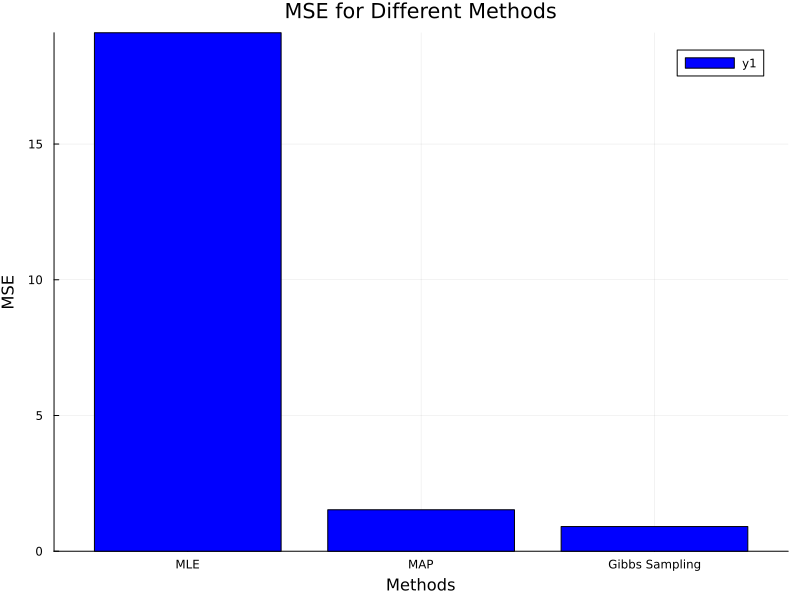

In [44]:
p2 = bar(method_names, mse_values, size= (800, 600), xlabel="Methods", ylabel="MSE", title="MSE for Different Methods", color=:blue)

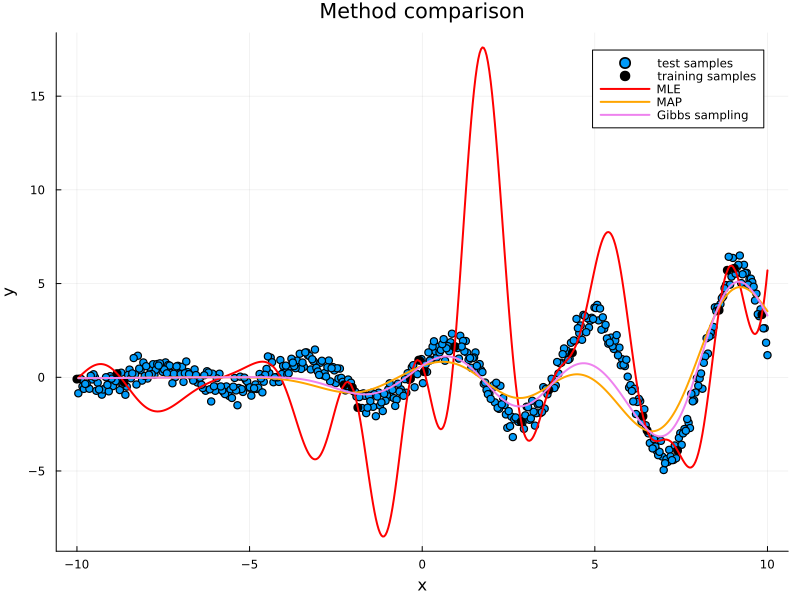

In [45]:
p1 = plot(xtest, ytest, size=(800, 600), seriestype = :scatter, label = "test samples", xlabel = "x", ylabel = "y", title = "Method comparison")
plot!(p1, xtrain, ytrain, seriestype = :scatter, label = "training samples", color = :black, ms= 5, xlabel = "x", ylabel = "y")
plot!(p1, xtest, ypred_mle, seriestype = :line, label = "MLE", color = :red, lw = 2)
plot!(p1, xtest, ypred_map, seriestype = :line, label = "MAP", color = :orange, lw = 2)
plot!(p1, xtest, ypred_gibbs, seriestype = :line, label = "Gibbs sampling", color = :violet, lw = 2)

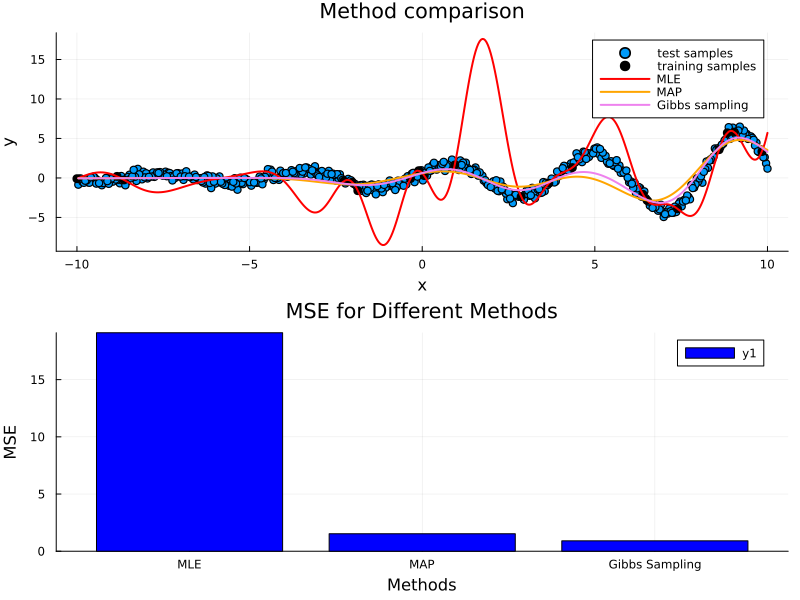

In [46]:
plot(p1, p2, layout = (2, 1))

# 5. Full Bayesian Inference

## 5.0 VI : General case

The very general case for Variational Inference (VI) given some parameters $w$ and some data $D$ is to learn an approximate distribution $q(w)$ of the true posterior $p(w|D)$ :

How do we choose this approximation? 

Clearly we want it to be as close as possible to the true posterior, so we will look at minimizing a similarity metric named the KL divergence:

The KL divergence is :

$$
KL(q || p) = \int q(w) \ln [\frac{q(w)}{p(w | D)}] dw \tag{74}
$$

So, we will strive to find the approximate distribution $q$ that minimizes the KL divergence:

$$
q^* \leftarrow \arg \min_{q(w)} KL(q || p)  \tag{75}
$$

Let's start with equation $(74)$. We have a logarithm, which means we can write the fraction under the logaritm as the numerator minus the denominator, and split the integral into two :

$$
KL(q || p) = \int q(w) \ln [q(w)] dw - \int q(w) \ln [p(w|D)] dw\tag{76}
$$

The first term of equation $(76)$ looks a lot like the negative entropy of the microcanonical ensemble (given that the energy at a site with be q). So we can write:

$$
- H(q) = \int q(w) \ln [q(w)] dw \tag{77}
$$

So our equation $(76)$ becomes:

$$
KL(q || p) = -H(q) - \int q(w) \ln [p(w|D)] dw\tag{78}
$$

Now, for the second term, we clearly have the posterior. It is easy to write this in terms of the full joint:

$$
p(w|D) = \frac{p(w, D)}{p(D)} \tag{79}
$$

Substituting $(79)$ into $(78)$ yields:

$$
KL(q || p) = -H(q) - \int q(w) \ln [p(w, D)] dw + \int q(w) \ln [p(D)] dw\tag{80}
$$

Expectation of a constant is just that constant:

$$
KL(q || p) = -H(q) - \int q(w) \ln [p(w, D)] dw + ln [p(D)] \tag{81}
$$

Now, substituing the form obtained in $(81)$ into $(75)$ yields:

$$
q^* \leftarrow \arg \min_{q(w)} (-H(q) - \int q(w) \ln [p(w, D)] dw )  \tag{82}
$$

Remembering that minimasing is maximising the negative:

$$
q^* \leftarrow \arg \max_{q(w)} (H(q) + \int q(w) \ln [p(w, D)] dw )  \tag{83}
$$


This is a very interesting and general result that shows that we maximize two things:

1. The entropy of q, which is just a regularization term
2. The expectation value over the full joint! 


Let's have another look at equation $(81)$. We know that the KL divergence, although not a distance, is strictly positive. So that translates into:

$$
\ln(p(d)) >= H(q) + \int q(w) \ln [p(w, D)] dw \tag{84}
$$

The term on the RHS of equation $(84)$ is Lower Bounded by the Evidence term! So it is:

$$
ELBO(q) = H(q) + \int q(w) \ln [p(w, D)] dw \tag{85}
$$

Now, going back to equation $(83)$, we see that we are actually minimising the ELBO:

$$
q^* \leftarrow \arg \max_{q(w)} ELBO(q)  \tag{86}
$$

We can also see this problem as minimizing the variational free energy, which is simply:

$$
F(q) = - ELBO(q) \tag{87}
$$

$$
q^* \leftarrow \arg \min_{q(w)} F(q)  \tag{88}
$$


This is a very general formulation of VI. It is important to note that $w$ is not a set of weight, but some parameters. In other words, $w$ can be $\mathbf{w}$, but also some other parameter like $\beta$. 

## 5.1 Mean Field Variational Inference (MFVI)

The following derivation is taken from Tran et al. : https://arxiv.org/pdf/2103.01327

We adapt it for the case at hand. 

Let's suppose the parameters $w$ are independent:

$$
w = (w_1, w_2)^T \tag{89}
$$

Since we assume they are independent, then we can write the approximate distribution $q$ as a product. **The assumptiom that the parameters $w$ are independent is key here!**:

$$ q(w) = q_1(w_1) q_2(w_2) \tag{90} $$

Let's substitute this into $(85)$, our formulation for ELBO: 


$$
ELBO(q_1, q_2) = \int q_1(w_1) q_2(w_2) \log{\frac{p(w, D)}{q_1(w_1) q_2(w_2)}}  dw_1 dw_2 \tag{91}
 $$

We can introduce some quite clever notation.

For example, in equation $(92)$ below we take the expectation with respect to everything but $w_1$ and we call this $E_{- w_1}$. This is useful because we can generalize to many parameters $w_1, \cdots, w_n$ :


$$ 
E_{- w_1}[\log{p(w, D)}] = \int q_2(w_2) \ln{p(w, D)} \, d w_2 \tag{92}
$$

We also have a term independent of $q_1$, which we can express as a constant that only depends on $q_2$ (which is actually the entropy with respect to $q_2$) :

$$H(q_2) = - \int q_2(w_2) \ln{q_2(w_2)} \, d w_2\tag{93}
$$

So, the Lower Bound effectively becomes:

$$
 ELBO(q_1, q_2) = \int q_1(w_1 ) E_{- w_1}[\ln{p(D, w)}] \, dw_1 - \int q_1(w_1) \ln{q_1(w_1)} \, dw_1 + H(q_2) \tag{94}
$$

Remembering that :

$$ x  = \ln{(\exp{x})} $$ 

We can write: 

$$ 
ELBO(q_1, q_2) = \int q_1(w_1 ) \ln{\exp{E_{- w_1}[\ln{p(D, w)}]}} \, dw_1 - \int q_1(w_1) \ln{q_1(w_1)} \, dw_1 + H(q_2) \tag{95}
$$

Further, we can combine the two integrals using the properties of the logarithm:

$$ 
ELBO(q_1, q_2) = \int q_1(w_1 ) \ln{ \frac{\exp{E_{- w_1}[\ln{p(D, w)}]}}{q_1(w_1)} }\, dw_1  + H(q_2) \tag{96}
$$

Let's introduce a probability density :

$$ 
\tilde{q_1} = \frac{\exp{(E_{- w_1}[\ln{p(D, w)}])}}{\tilde{H}(q_2)} \propto \exp{(E_{- w_1}[\ln{p(D, w)}])} \tag{97}
$$

Where:

$$ 
\tilde{H}(q_2) = \int \exp{(E_{- w_1}[\ln{p(D, w)}])} \, dw_1 \tag{98}
$$

This means we can write the exponential term as :

$$ 
\tilde{q_1}(w_1) \tilde{H}(q_2)  = \exp{E_{- w_1}[\log{p(D, w)}]} \tag{99}
$$

Substituting $(99)$ into $(96)$ yields :

$$ 
ELBO(q_1, q_2) = \int q_1(w_1 ) \ln{\frac{\tilde{q_1}(w_1)}{q_1(w_1)}} \, dw_1  + H(q_2) + \tilde{H}(q_2) \tag{100}
$$

We can see that we have reduced the lower bound to another KL divergence and to a constant independent of $q_1$ :

$$ 
ELBO(q_1, q_2) = - KL(q_1 || \tilde{q_1} ) + \text{const}(q_2) \tag{101}
$$

Now, we can do the same treatment for $q_2$ (the sitution is symmetric) :


$$ 
ELBO(q_1, q_2) = - KL(q_2 || \tilde{q_2} ) + \text{constant}(q_1) \tag{102}
$$

Now, maximising ELBO means minimizing the newly defined KL divergences, which clearly occurs (for a random number of independent terms) when 

$$
\tilde{q_i} = q_{i}  \tag{103}
$$

So, for a random $w_i$ belonging to $w$ we have a $q_i(w_i)$ :

$$
\tilde{q_i}(w_i) \propto \exp{ \{ E_{- w_i}[\ln{p(D, w)}] \}} \tag{104}
$$

So, we take the expectation of everything else of the full joint! This is an important result, as it allows us to apply it to the problem at hand in a straightforward fashion. 


## 5.2 MFVI Implementation 

Now let us apply the previous calculations to our problem. But first we need some assumptions on our priors. These assumptions are the same as for Gibbs Sampling : 



$$
p(\bf w \vert \mathbf{0}, \alpha) = N(\mathbf{w} ; 0, \mathbf{A}^{-1}) \tag{35}
$$

With :

$$ 
\mathbf{A} = diag(\alpha_1, \cdots, \alpha_m)  = diag(\mathbf{\alpha}) \tag{36}
$$

We recall equation $(66)$ for our prior for $\bf \alpha$

$$
p(\mathbf{\alpha}) = \prod_{j=1}^{n} \frac{b^{a}}{\Gamma (a)} \alpha_j^{a-1} (\exp{(- b \alpha_j)}) \tag{66}
$$

And for $\beta$: 


$$
p(\beta) = Gamma(\beta; c, d ) \tag{52}
$$

Analytically this is :


$$
p(\beta; c, d) = \frac{d^{c}}{\Gamma (c)} (\exp{(- d \beta)}) \beta^{(c-1)} \tag{53}
$$




Now, as per equation $(104)$ we can start with the joint distribution. Its application is straightforward, because $w = \mathbf{w, \alpha}, \beta$. Let us start with the chain rule:

$$
p(\mathbf{w, \alpha, y}, \beta | \mathbf{\Phi}) = p(\mathbf{w | \alpha}) p(\beta) p(\mathbf{\alpha}) p(\mathbf{y} | \mathbf{w, \alpha}, \beta, \mathbf{\Phi}) \tag{105}
$$

We can apply the logarithm which transforms the product into a sum :

$$
\ln p(\mathbf{w, \alpha, y}, \beta | \mathbf{\Phi}) = \ln p(\mathbf{w | \alpha}) + \ln p(\beta) + \ln p(\mathbf{\alpha}) +\ln  p(\mathbf{y} | \mathbf{w, \alpha}, \beta, \mathbf{\Phi}) \tag{106}
$$



Now, let us calculate each expectation

### 1. $q(\mathbf{w})$

Based on $(104)$ (we can take the logarithm) :

$$
\ln{q(\mathbf{w})} = E_{-\mathbf{w}} [\ln p(\mathbf{w, \alpha, y}, \beta | \mathbf{\Phi})] \tag{107}
$$

Recalling $(107)$ we can write:

$$
\ln{q(\mathbf{w})} = E_{-\mathbf{w}} [\ln p(\mathbf{w | \alpha}) + \ln p(\beta) + \ln p(\mathbf{\alpha}) +\ln  p(\mathbf{y} | \mathbf{w, \alpha}, \beta, \mathbf{\Phi})] \tag{108}
$$

But only the terms that contain $w$ are of interest! This is because the rest are constants (w.r.t to $\mathbf{w}$) :

$$
\ln{q(\mathbf{w})} = E_{-\mathbf{w}} [\ln p(\mathbf{w | \alpha}) + \ln  p(\mathbf{y} | \mathbf{w, \alpha}, \beta, \mathbf{\Phi})] \tag{109}
$$

Since we know the forms of the terms under the expectation, and also that the expectation with respect to anything but $\mathbf{w}$ is simply of the remaining $\mathbf{\alpha}, \beta$ we can write :



$$
\ln{q(\mathbf{w})} = E_{\mathbf{\alpha}, \beta} [- \frac{1}{2} {\bf w^T A w} + \text{const}  - \frac{1}{2} \beta (\mathbf{y - \Phi w})^T (\mathbf{y - \Phi w})] \tag{110}
$$

We recognize that $(110)$ is simply completing the square, as we did for Gibbs sampling, but now our mean and covariance are slightly different. So essentially, our distribution is just a Gaussian:

$$
q(\mathbf{w}) = N(\mathbf{w}; \bf \mu_N, \Sigma_N) \tag{111}
$$

With the following parameters

$$
\mathbf{\Sigma_N} = [<A>_{q(\mathbf{\alpha})} + <\beta>_{q(\beta)} {\bf \Phi^T \Phi}]^{-1} \tag{112}
$$

$$
\mathbf{\mu_N} = \mathbf{\Sigma_M} (<\beta>_{q(\beta)} {\bf \Phi^T y}) \tag{113}
$$

As an interesting observations, we can compare them with the expressions for Gibbs Sampling : 

$$
\mathbf{\Sigma} = (\beta \mathbf{\Phi}^T \mathbf{\Phi} + \mathbf{A})^{-1} \tag{43}
$$

$$
\mathbf{\mu} = \beta \bf \Sigma \Phi^T  y  \tag{49}
$$






### 2. $q(\mathbf{\alpha})$

Our starting point is exactly the same as in the previous example. We take the expectation with respect to everything but $\alpha$ and then we keep only the relevant terms (that depend on $\alpha$ in this case)

$$
\ln{q(\mathbf{\alpha})} = E_{\mathbf{w}, \beta} [\ln p(\mathbf{w | \alpha}) + \ln  p(\mathbf{\alpha})] \tag{114}
$$

Knowing that the first term is the log of a Gaussian and the second is the log of a Gamma can simplify $(114)$. Let us recall $(38)$ :

$$ 
 N(\mathbf{w} ; 0, \mathbf{A}^{-1}) = (\frac{1}{2 \pi})^{\frac{n}{2}} \frac{1}{\vert  \mathbf{A}^{-1} \vert^{\frac{1}{2}}} \exp{(- \frac{1}{2} \mathbf{w}^T \mathbf{A} \mathbf{w})} \tag{38}
$$

Taking the logarithm of $(38)$ and writing the quadratic term as a sum yields:

$$
\ln p(\mathbf{w | \alpha}) = +\frac{1}{2} \ln |\mathbf{A}|  - \frac{1}{2} \sum_{j=1}^{n} a_j w_j^2  \tag{115}
$$

Similarly, taking the logarithm of $(66)$ :

$$
\ln p(\mathbf{\alpha | w}) =  \frac{b^{a}}{\Tau (a)}  + \sum_{j=1}^{n} (a -1) \ln \alpha_j - \sum_{j=1}^{n} \alpha_j b \tag{116}
$$

Now let us insert $(115)$ and $(114)$ into $(113)$ (I ignore the constant as it is not important under expectation):

$$
\ln{q(\mathbf{\alpha})} = E_{\mathbf{w}, \beta} [\frac{1}{2} \ln |\mathbf{A}| -  \frac{1}{2} \sum_{j=1}^{n} a_j w_j^2 + (a-1) ln |\mathbf{A}| - \sum_{j=1}^{n} \alpha_j b] \tag{117}
$$


Now, this is again very simillar to the previous calculation we did in Gibbs Sampling. The difference is that we know have an expectation over $w_j^2$ to consider. But otherwise, is is clear that our $q(\mathbf{\alpha})$ is a product of Gamma functions :

$$
q(\mathbf{\alpha}) = \prod_{j=1}^{n} Gamma(\alpha_j ;a_d, b_d) \ \tag{118}
$$


The two parameters of each Gamma under the product are easy to identify as :

$$
a_d = a + \frac{1}{2} \tag{119}
$$

$$
b_d = b + \frac{1}{2} <{w_j^2}>_{q(\mathbf{w})} = b + \frac{1}{2}  (C_N + \mu_N^T \mu_N) \tag{120}
$$


Let us compare with what we found for Gibbs Sampling :

$$ 
\tilde{a} = a + \frac{1}{2} \tag{72}
$$

$$
\tilde{b} = b +  \frac{1}{2} w_j^2  \tag{73}
$$

### 3. $q(\beta)$

Our starting point is no different. We very easily arrive at :


$$
\ln{q(\beta)} = E_{\mathbf{w , \alpha}} [ \ln p(\beta) + \ln  p(\mathbf{y} | \mathbf{w, \alpha}, \beta, \mathbf{\Phi})] \tag{121}
$$



Let's recall the analytical form of the $\beta$ prior : 

$$
p(\beta; c, d) = \frac{d^{c}}{\Gamma (c)} (\exp{(- d \beta)}) \beta^{(c-1)} \tag{53}
$$

Taking the logarithm :

$$
\ln p(\beta; c, d) = \ln{\frac{d^{c}}{\Gamma (c)}}  - d \beta +  (c - 1) \ln{\beta}  \tag{121}
$$

So, inserting $(120)$ and the vectorized form of $(8)$ into $(119)$ yields:


$$
\ln{q(\beta)} = E_{\mathbf{w , \alpha}} [ - d \beta +  (c - 1) \ln{\beta}  +  - \frac{1}{2} \beta (\mathbf{y - \Phi w})^T (\mathbf{y - \Phi w}) ] \tag{122}
$$



### The Trace Trick

Before we go any further, let us recall a very useful trick for taking the expectation :

$$
<\bf w^T \Delta w >_{w} = tr[ \mathbf{\Delta} <w^T w>_{w}] \tag{123}
$$

### Gaussian Covariance

Let's also recall that the covariance of a Gaussian can be written as:

$$
\bf \Sigma = <w^T w> - <w> <w>^T 
$$

Now, in equation $(121)$, we can write multiply the brackets to get:


$$
\ln{q(\beta)} = E_{\mathbf{w , \alpha}} [ - d \beta +  (c - 1) \ln{\beta}  + \frac{n}{2} \ln{\beta} - \frac{1}{2} \beta (\bf y^T y - 2 y^T \Phi w + w^T \Phi^T \Phi w )] \tag{124}
$$

The expectation for the quadratic term of equation $(124)$ can be simplified via the trace trick:

$$
<( \mathbf{w^T \Phi^T \Phi w} )>_{q(\mathbf{w})} = tr(\mathbf{\Phi^T \Phi} <\mathbf{w^T w}>_{q(\mathbf{w})}) \tag{125}
$$

But using what we know of the covariance from equation $(123)$, we can re-write $(125)$:

$$
<( \mathbf{w^T \Phi^T \Phi w} )>_{q(\mathbf{w})} = tr(\mathbf{\Phi^T \Phi} ({\bf \Sigma_N + \mu_N^T \mu_N})) \tag{126}
$$

We also used that over the distribution $q(\mathbf{w})$ the expectation of $\mathbf{w}$ is simply the mean $\mu_N$ in $(126)$ Going back to $(124)$ we can write it as:

$$
\ln{q(\beta)} =  [ - d \beta +  (c - 1) \ln{\beta}  + \frac{n}{2} \ln{\beta} - \frac{1}{2} \beta (\bf y^T y - 2 y^T \Phi \mu_N + tr(\mathbf{\Phi^T \Phi} ({\bf \Sigma_N + \mu_N^T \mu_N})))] \tag{127}
$$

$$
\ln{q(\beta)} =  [ - d \beta +  (c - 1) \ln{\beta}  + \frac{n}{2} \ln{\beta} - \frac{1}{2} \beta (\bf y^T y - 2 y^T \Phi \mu_N + tr(\mathbf{(\Phi^T \Phi \mathbf{\Sigma_N})}) +  tr(\mathbf{(\Phi^T \Phi \mathbf{\mu_N^T \mu_N})} ] \tag{128}
$$




For the last trace in equation $(128)$, we recognize the trace trick that was applied and the fact that its expectation over $(q(\mathbf{w}))$ is just itself

$$
\ln{q(\beta)} =  [ - d \beta +  (c - 1) \ln{\beta} + \frac{n}{2} \ln{\beta}   - \frac{1}{2} \beta (\bf y^T y - 2 y^T \Phi \mu_N + {\bf \mu_N \Phi^T \Phi \mu_N} + tr(\mathbf{\Phi^T \Phi \mathbf{\Sigma_N}}) ) ] \tag{129}
$$

We can recognize the sqaured term :

$$
\ln{q(\beta)} =  [ - d \beta +  (c - 1) \ln{\beta}  +\frac{n}{2} \ln{\beta}  - \frac{1}{2} \beta (\bf || y - \Phi \mu_N ||^{2} + tr\mathbf{(\Phi^T \Phi \mathbf{\Sigma_N})} ) ] \tag{130}
$$

So, once again we recognize a clear Gamma function such that:

$$ 
c_N = c + \frac{n}{2} \tag{131}
$$

$$
d_N = d+ \frac{1}{2} (\bf || y - \Phi \mu_N ||^{2} + tr(\Phi^T \Phi \Sigma_N )) \tag{132}
$$

For comparison purposes, let us recall what these were for Gibbs Sampling :

$$ 
\tilde{c} = c + \frac{n}{2} \tag{57}
$$

$$ 
\tilde{d} = d + \frac{1}{2}  (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) ^ T (\mathbf{y} - \mathbf{\Phi} \mathbf{w}) \tag{58}
$$


OBservations:

- Our results are actually very simillar to Gibbs sampling, but in MFVI we do NOT sample from the posteriors, but we update using expectations!

In [47]:
function update_w(y, ct, dt, Φ, at, bt)
    """
    Calculates value of 
    q(w) based on expectation

    Implements a Gaussian with :

    - mean μ_N (Equation 113)
    - covariance Σ_N (equation 112)
    """
    
    # q(α) is Gamma so the expectation is 
    # diagonal with a, b
    # term in equation 112

    Â = Diagonal(at ./ bt)

    # q(β) is Gamma function, so we know 
    # the expectation of β in equation 113
    # is a scalar
    β̂ = ct / dt 


    ## Equation 112
    Σ_Ninv = β̂ * Φ' * Φ + Â
    Σ_N = inv(Σ_Ninv)

    ## equation 113
    μ_N = β̂ * Σ_N * Φ' * y 

    return Σ_N, μ_N

end

update_w (generic function with 1 method)

In [48]:
function update_α(b, Σ_N, μ_N)
    """
    Function that updates the precision
    of the weights.
    """
    
    # Equation 120(we used the covariance defitinio
    expect = diag(Σ_N) .+ μ_N' * μ_N
    b_d = b .+ 0.5 *(expect)

    return b_d

    end


update_α (generic function with 1 method)

In [49]:
function update_β(Φ, y, d, Σ_N, μ_N)
    """
    update the precision of the noise.
    """

    # Equation 132
    term = sum((y - Φ * μ_N )'* (y - Φ * μ_N )) + tr(Φ' * Φ * Σ_N)
    d_N = d + 0.5 * term

    return d_N

end

update_β (generic function with 1 method)

The implementation below was checked and compared to : https://lf28.github.io/MSc_2024/Bayes3_sol.html

In [50]:
function viBayesianLR(Φ, ytrain , a0=0, b0=0, c0=1e-6, d0=1e-6, maxIters=100)
	N, M = size(Φ)
	# initialisation for q(β) 
	# notice that these are not vectors, because β
	# is a scalar
	ct = c0 + N/2 # Equation 131; to avoid lopp
	dt = d0 + var(ytrain) * N /2 


	# initialisation for q(α)
	at = a0 + 0.5 # Equation 119; to avoid loop
	bt = b0 .+ 0.5 * ones(M)


	# initialisation for q(w)
	mₙ = zeros(M)
	Cₙ = Diagonal(ones(M))

    # loop 
	for i in 1:maxIters
		# update q(w)

		Cₙ, mₙ = update_w(ytrain, ct, dt, Φ, at, bt)
        
		# update q(β)

		dt = update_β(Φ, ytrain, dt, Cₙ, mₙ)


		# update q(α)
		bt = update_α(bt, Cₙ, mₙ)

		
	end
	return mₙ, Cₙ, at, bt, ct, dt
end

viBayesianLR (generic function with 6 methods)

In [51]:
a0 = 1e-6
b0 = 1e-6
c0 = 1e-6
d0 = 1e-6

ws, Cs,  as, bs, cs ,ds  = viBayesianLR(Φ_train, ytrain , a0, b0, c0, d0)

([-1.649498378022454, 0.4077137979337739, -1.512296406403966, -3.2734404464893605, 4.068004333874312, -4.637611677938768, 5.66654999019126, -0.030442492601650547, -0.030120798624719655, 0.005584316859715367, -0.033498651697678586, 3.3161761424178273, -0.4388020142237504, 1.462488849847803, -3.688260419833903, -1.7876292975791446, 1.6176885559249405, 0.29887721203178397, 5.206294593073367, -3.779758165242149], [1.3530675979831253e19 4.3414773055242485e15 … 9.400274470082563e16 -5.87408716968286e14; 4.34147730552957e15 1.1694059070343615e20 … 2.516722521249079e15 4.573527331695623e17; … ; 9.400274470082688e16 2.5167225212463585e15 … 3.8446619308151005e19 -4.9417154195237556e14; -5.874087169694852e14 4.5735273316821824e17 … -4.9417154195298294e14 9.286120199933913e19], 0.500001, [2.021356818756031e19, 1.7403578639960998e20, 4.69845313528739e18, 4.524834792992539e19, 1.0887437018778717e20, 4.962155210551323e18, 9.315534614472358e19, 2.111012329934275e20, 5.993844410580244e18, 6.27503668471

In [52]:
ws

20-element Vector{Float64}:
 -1.649498378022454
  0.4077137979337739
 -1.512296406403966
 -3.2734404464893605
  4.068004333874312
 -4.637611677938768
  5.66654999019126
 -0.030442492601650547
 -0.030120798624719655
  0.005584316859715367
 -0.033498651697678586
  3.3161761424178273
 -0.4388020142237504
  1.462488849847803
 -3.688260419833903
 -1.7876292975791446
  1.6176885559249405
  0.29887721203178397
  5.206294593073367
 -3.779758165242149

In [53]:
size(Φ_test)

(480, 20)

In [54]:
function predict_vi(Φ_test, ws) 
    """
    Computes predictions by drawing samples
    for weights, weight variance and noise variances.
    The uncertainty in predictions is quantified by
    both signal noise β and weight variances αₘ⁻¹

    Args:

    Φ_test : design matrix for test set(n_test  x n_basis)
    ws : weight samples (n_basis x mc samples )
    αs : weight precision (n_basis x mc samples)

    βs : noise  precision (1  x mc samples)
    """

    # samples for each predict
    y_samples = Φ_test * ws 
 
    # mean for each sample row (these are my expected values)
    y_means = mean(y_samples, dims = 2)

    return y_means
    
    end



predict_vi (generic function with 1 method)

In [55]:
ypred_mfvi = predict_vi(Φ_test, ws)

480-element Vector{Float64}:
 -2.274929119226466
 -1.35177899374809
  0.03804079956455911
 -1.0455328473592522
  0.8501190274066533
  0.08368008016466359
  0.5143517980241444
 -0.03981855023708282
  0.07971303178762273
 -1.2931132467277346
  1.2052933650015536
  0.14037673000016304
  0.18878061463137083
  ⋮
  9.95128749747784e-5
  0.10901261234461926
 -1.2618919719339403
 -1.1630989227096624
 -1.0170392141019184
 -0.618817469260166
 -3.2180449222856913
 -1.2369441792418998
  0.0011808016945645179
 -0.8314448832389758
 -0.6287738138341237
  0.6539703908313306

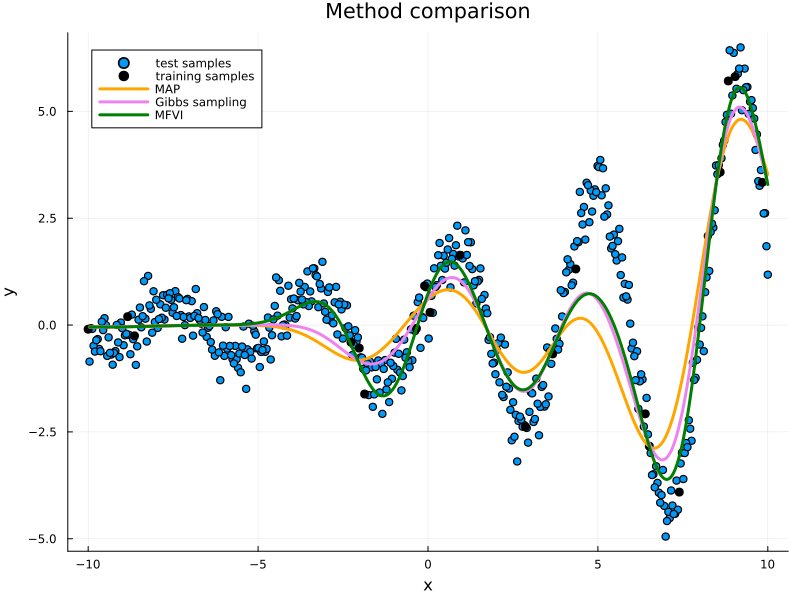

In [60]:
p1 = plot(xtest, ytest, size=(800, 600), seriestype = :scatter, label = "test samples", xlabel = "x", ylabel = "y", title = "Method comparison")
plot!(p1, xtrain, ytrain, seriestype = :scatter, label = "training samples", color = :black, ms= 5, xlabel = "x", ylabel = "y")
#plot!(p1, xtest, ypred_mle, seriestype = :line, label = "MLE", color = :red, lw = 2)
plot!(p1, xtest, ypred_map, seriestype = :line, label = "MAP", color = :orange, lw = 3)
plot!(p1, xtest, ypred_gibbs, seriestype = :line, label = "Gibbs sampling", color = :violet, lw = 3)
plot!(p1, xtest, ypred_mfvi, seriestype = :line, label = "MFVI", color = :green, lw = 3)


LEt's see the mean squared error for MFVI

In [61]:
mse_test_mfvi = mse_pred(ytest, ypred_mfvi)

0.6999207947904609

In [62]:
begin
    method_names = [ "MAP", "Gibbs Sampling", "MFVI"]
    mse_values = [mse_test_map, mse_test_gibbs, mse_test_mfvi]
end

3-element Vector{Float64}:
 1.5269310986508773
 0.9083552065505317
 0.6999207947904609

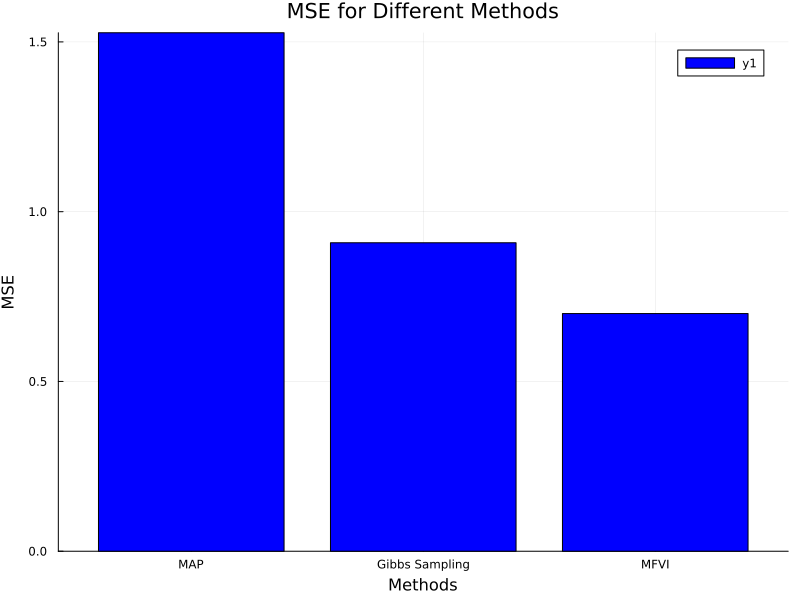

In [63]:
p2 = bar(method_names, mse_values, size= (800, 600), xlabel="Methods", ylabel="MSE", title="MSE for Different Methods", color=:blue)

Observe:

- MFVI is slightly better than Gibbs sampling, and they are both an improvement over MAP

## 5.3 Fixed Form VI : :FFVI

For fixed form we assume that our approximating distribution is fixed (known). This doesn't mean we make any assumptions on the prior:

$$
q(\mathbf{w}) = N(\mathbf{w; m, V}) \tag{133}
$$

Analytically this is :

$$
q(\mathbf{w}) =(\frac{1}{2 \pi})^{\frac{D}{2}} \frac{1}{|V|^{\frac{1}{2}}} \exp{\{ -\frac{1}{2} \mathbf{(w - m)^T V^{(-1)} (w-m)} \} } \tag{134}
$$

We can take the logarithm on both sides of $(134)$ which yields:

$$
\ln q(\mathbf{w}) =- {\frac{D}{2}} \ln{(2 pi)} - \frac{1}{2} \ln{(|\mathbf{V}|)}  -\frac{1}{2} \mathbf{(w - m)^T V^{(-1)}(w-m)} \tag{135}
$$



Let's recall that our entropy  is:

$$
- H(q) = <\ln{(q(\mathbf{w}))}>_{q(\mathbf{w})} \tag{136}
$$

Now we can recall that for the previous case, in euqations $(122) - (130)$ we had to calculate the expectation of a very simillar quadratic term as in equation $(135)$ and we have applied the trace trick to do it. The treatment is very simillar here.

$$
- H(q) =- {\frac{D}{2}} \ln{(2 \pi)} - \frac{1}{2} \ln{(|\mathbf{V}|)}  -\frac{1}{2} <\mathbf{(w - m)^T V^{(-1)}(w-m)}>_{q(\mathbf{w})} \tag{137}
$$

We are interested in the expectation of the quadratic term : 


$$
<\mathbf{(w - m)^T V^{(-1)}(w-m)}>_q(\mathbf{w}) = <\mathbf{w^{T} V^{(-1)} w - 2 m^{T} V^{(-1)} w + m^T V^{(-1)} m}>_{q(\mathbf{w})}  \tag{138}
$$

We can see that the last term of the kernel is just a constant, the second term contains practically the mean, wihch means only first term must be computed,


$$
<\mathbf{(w - m)^T V^{(-1)}(w-m)}>_q(\mathbf{w}) = <\mathbf{w^{T} V^{(-1)} w}>_{q(\mathbf{w})}- 2 \mathbf{m^{T} V^{(-1)} m}+ \mathbf{m^T V^{(-1)} m}\tag{139}
$$

Now, let us take the first term and apply the tracke trick:

$$
<\mathbf{w^{T} V^{(-1)} w}>_{q(\mathbf{w})} = tr(\mathbf{V^{-1}} <\mathbf{w^{T} w}>_{q(\mathbf{w})} ) \tag{140}
$$

We also see that the expectation of the weights product is just the variance and the product of means :

$$
<\mathbf{w^{T} V^{(-1)} w}>_{q(\mathbf{w})} = tr(\mathbf{V^{-1} (V + m m^T )}) \tag{141}
$$

We make use that the trace of a sum is the trace of individual elements of that sum : 

$$
<\mathbf{w^{T} V^{(-1)} w}>_{q(\mathbf{w})} = tr(\mathbf{V^{-1} V})  + tr(\mathbf{V^{-1}m m^T }) \tag{142}
$$

Recognizing in $(142)$ that the first trace is just the trace of an identity matrix, and the second trace is the expectation over a constant quadratic term we can write:

$$
<\mathbf{w^{T} V^{(-1)} w}>_{q(\mathbf{w})} = D + \mathbf{m^T V^{-1} m } \tag{143}
$$

Now, let us plug $(143)$ into $(139)$: 

$$
<\mathbf{(w - m)^T V^{(-1)}(w-m)}>_q(\mathbf{w}) = D + \mathbf{m^T V^{-1} m }- 2 \mathbf{m^{T} V^{(-1)} m}+ \mathbf{m^T V^{(-1)} m}\tag{144}
$$

This is very clearly just :

$$
<\mathbf{(w - m)^T V^{(-1)}(w-m)}>_q(\mathbf{w}) = D \tag{145}
$$

Let us plug $(145)$ back into the entropy term in $(137)$ : 

$$
- H(q) =- {\frac{D}{2}} \ln{(2 \pi)} - \frac{1}{2} \ln{(|\mathbf{V}|)}  - D \tag{146}
$$

It is difficult to optimize $\bf V$. So we perform Cholesky (a type of$LU$ ) decomposition such that :

$$
\bf V = L L^T \tag{147}
$$

Now, when we take the determinant, this is just the product of the determinants of the individual matrices. But for the Upper-Triangular $L^T$ the determinant is 1. This means:

$$
\bf |V| = |L||L^T| \tag{148}
$$

$$
\bf |V| = |L|^2 \tag{148}
$$

And since $L$ is lower triangular, we can write it as a product of its diagonal elements:

$$
\mathbf{|V|} = \prod_{d=1}^{D} L_{dd}\tag{149}
$$

Now, let us recall that the variational energy is :

$$
F(q) = - H(q) - <\ln p(\mathbf{w, \alpha, y}, \beta | \mathbf{\Phi})>_{q(\mathbf{w})} \tag{150}
$$

Essentially, we need the expectation over the full joint. Now, let us combine $(150)$ with $(146)$ and with $(149)$ :

$$
F(q) = - {\frac{D}{2}} \ln{(2 \pi)}  - D - \sum_{d=1}^D \ln{L_{dd}} - <\ln p(\mathbf{w, \alpha, y}, \beta | \mathbf{\Phi})>_{q(\mathbf{w})} \tag{151}
$$

Our problem now is practically an optimization problem. But instead of optimizing for $\bf m, V$, we now optimize for $\bf m , L$ due to our decomposition of the matrix $\bf V$. Now, the gradient of the sum term is straightforwad:

$$
\nabla_{L} \sum_{d=1}^D \ln{L_{dd}} = diag({L_{dd}^{-1}}) I \tag{152}
$$

But the problem now becomes taking the gradients of the expectation of the full joint, an expectation which depends on $q(\mathbf{w})$. But we can apply a reparametrisation trick. Instead of taking the expectation over :

$$ 
q(\mathbf{w}) = N(\mathbf{w; m , V})
$$

,which is hard because we first must calculate the expectation and then carefully compute the gradients, we can instead take the expectation over a different parameter $\nu$ such that there exists a linear transformation:

$$ 
\bf w = m + L \nu \tag{153}
$$

`We can prove that`:

$$
<f(\mathbf{w})>_{\mathbf{w} \sim N(\mathbf{m, V})} = <f(\mathbf{\nu})>_{\mathbf{\nu} \sim N(\mathbf{0, I})} \tag{154}
$$

So when taking the gradient with respect to $\bf m$ on both sides of $(154)$:

$$
\nabla_{\mathbf{m}} <f(\mathbf{w})>_{\mathbf{w} \sim N(\mathbf{m, V})} = \nabla_{\mathbf{m + L \nu}} <f(\mathbf{m + L \nu})>_{\mathbf{\nu} \sim N(\mathbf{0, I})} \tag{155}
$$

The result is similar when taking the gradient with respect to $L$, but we must remember to apply the chain rule and also differentiate the argument of the function :

$$
\nabla_{\mathbf{L}} <f(\mathbf{w})>_{\mathbf{w} \sim N(\mathbf{m, V})} = \nabla_{\mathbf{m+ L\nu}} <f(\mathbf{m + L \nu}) \nu^T \circ \mathbf{S_L}>_{\mathbf{\nu} \sim N(\mathbf{0, I})} \tag{156}
$$

Notice that I added $ \circ $. This is the Hadamard product, a binary operation taking two matrices and returning their entry-wise product. Here, $\mathbf{S_L} $ is a Lower triangular matrix, with 0 above the diagonal and 1 beneath it, that ensures the expectation respect the form of the lower triangular matrix $L$. 

### Monte Carlo Unbiased Gradient approximation

We can approximate the gradients using MC sampling. There are basically to steps:

1. Sample $\nu^{s} \sim N(\mathbf{0, I})$

2. Apply the linear transform $ \bf w^s = m + L \nu^{s}$

Following from $(151)$, the gradients with respect to $\bf m, L$ applied to the free variational energy $F(q)$ is :

$$
\nabla_{\mathbf{m}} F = - \nabla_{\mathbf{m}} <\ln p(\mathbf{w, \alpha, y}, \beta | \mathbf{\Phi})>_{q(\mathbf{w})} \tag{157}
$$

$$
\nabla_{\mathbf{L}} F = - \nabla_{L} \sum_{d=1}^D \ln{L_{dd}}- \nabla_{\mathbf{L}} <\ln p(\mathbf{w, \alpha, y}, \beta | \mathbf{\Phi})>_{q(\mathbf{w})} \tag{158}
$$

We can apply the transformation in $(155)$ to $(157)$:

$$
\nabla_{\mathbf{m}} F = - \nabla_{\mathbf{m + L \nu}} <\ln p(\mathbf{m + L\nu, \alpha, y}, \beta | \mathbf{\Phi})>_{\nu \sim N(\mathbf{0, I})} \tag{159}
$$

This is an expectation value over a constant distribution, which means it is just an integral over $\nu$. We can definitely move the gradient inside the expectation

$$
\nabla_{\mathbf{m}} F =  - <  \nabla_{\mathbf{m + L \nu}} \ln p(\mathbf{m + L\nu, \alpha, y}, \beta | \mathbf{\Phi})>_{\nu \sim N(\mathbf{0, I})}\tag{160}
$$

Now, we can approximate this expectation, which can be intractable, with a monte carlo average, such that :

$$
\nabla_{\mathbf{m}} F \approx - \frac{1}{M} \sum_{i=1}^{M} \nabla_{\mathbf{w^{(i)}}} \ln p(\mathbf{w^{(i)}, \alpha, y}, \beta | \mathbf{\Phi})\tag{161}
$$

Now, similarly, let us use the transformation in $(156)$ and the result $(152)$ for $(158)$ :

$$
\nabla_{\mathbf{L}} F = - diag({L_{dd}^{-1}}) I  - \nabla_{\mathbf{L + m\nu}} <\ln p(\mathbf{m+L\nu, \alpha, y}, \beta | \mathbf{\Phi}) \nu^T \circ S_L>_{q(\mathbf{w})} \tag{162}
$$

As before we can approximate this with monte carlo 


$$
\nabla_{\mathbf{L}} F = - diag({L_{dd}^{-1}}) I  - \frac{1}{M} \sum_{i=1}^{M} \nabla_{\mathbf{w^{(i)}}} \ln p(\mathbf{w^{(i)}, \alpha, y}, \beta | \mathbf{\Phi}) \nu^{(m)T} \circ S_L \tag{163}
$$

```We can now reparametrize the diagonal entries of $L$ such that they are positive. We can do this by multiplying the diagonal entries with $ \exp{L_{dd}^*}$. Since we are multiplying the diagonal entries, we can again use the Haddamard product becuase it allows us to multiply these entries directly. Taking the gradient of the```  :

$$
\nabla_{\mathbf{L^*}} F = - \nabla_{L} F \circ diag({\exp(L_{dd}^*)}) = - \nabla_{L} F \circ diag((L_{dd}))  \tag{164}
$$




## 5.4 FFVI Implementation

Functions below taken from : https://lf28.github.io/MSc_2024/Bayes3_sol.html

In [3]:
begin
    
    function pack_L(LL)
        """
        Repararemetrizes the diagonal entries of the matrix LL
        """
        # Get the ids of diagonal elements
        diagidx = diagind(LL)
        # extract the lower triangular matrix
        L = tril(LL)
        # apply (element-wise the diaognal transformation to the matrix)
        L[diagidx] = exp.(diag(LL))

        return L
    end
end

pack_L (generic function with 1 method)

In [ ]:
begin
    function svi_grad(mm, LL, l; mc = 1, mf = false)

        """
        Function that implements the gradient of the free energy.

        mm : mean 
        LL : L part( of Variance V)

        """

        D = size(mm)[1]
        diagidx = diagind(LL)


        if !mf

            L = pack_L(LL)

        else 

            L = Diagonal(exp.(diag(LL))) 

        end 

        # implement variational energy according to 


        ℱ = -0.5 * D - 0.5 * D * log(2 * π) - sum(diag(LL)) # this looks life 151, with Mean Field Assumption?

        # sammple ν
	    ν = randn(D, mc)

        # compute w
	    ww = mm .+ L * ν

        
	    ℓs, ∇ws = ℓ(ww)
	    ℱ -= mean(ℓs)
	    ∇m = - mean(∇ws, dims=2)[:]
	    ∇L = - tril((1 / mc) .* ∇ws * ν') 
	    ∇L[diagidx] = (∇L[diagidx] .* L[diagidx]) 
	    ∇L -= I
	#  fixed form plus mean field assumption: i.e. isotropic diagonal Gaussian
	if mf
		∇L = Diagonal(diag(∇L)) 
	end
	return ∇m, ∇L, ℱ
end
        
    end


end

# 6. EM-Based Bayesian Linear Regression

Adapted from : https://ieeexplore.ieee.org/document/4644060

We can use many of the previously derived equations.

Let's recall the likelihood of the data, given the parameters. 

$$
p(\mathbf{y} | \mathbf{w, \Phi}, \beta) = \prod_{i=1}^{n}  p(y^{(i)} \vert (\mathbf{\Phi} \mathbf{w})^{(i)}, \beta^{-1}) \tag{4}
$$

Now, if we apply Bayes' rule (as before) we get the posterior :


$$ 
p(\mathbf{w} \vert \mathbf{y}, \mathbf{\Phi}, \beta^{-1}, \mathbf{\alpha}) = \frac{ p(\mathbf{y} \vert \mathbf{w}, \mathbf{\Phi}, \beta^{-1})  p(\mathbf{w \vert \alpha}) }{p(\mathbf{y})} \tag{34}
$$

Also let us consider the same choices as before. A Gaussian for the prior and a Gaussian for the likelihood. This means :


$$
p(\mathbf{y} \vert \mathbf{w, \Phi}, \beta) = N (\mathbf{y} ;\mathbf{\Phi} \mathbf{w}, \beta^{-1} \mathbf{I})
$$

And also for the prior :

$$
p(\bf w | \alpha) = N(\mathbf{w} ; 0, \mathbf{A}^{-1})
$$


Now, we can express the evidence term as :


$$
p(\mathbf{y})=\int p(\mathbf{y}\vert \mathbf{w}, \Phi, \beta)p(\mathbf{w}|\mathbf{\alpha})d{\bf w}
$$

The calculation for the term under the integral (the product of the prior and the posterior) was done previously in equations $(37) - (49)$. We have shown that the solution is just a Gaussian with the following mean and covariance :


$$
\mathbf{\Sigma} = (\beta \mathbf{\Phi}^T \mathbf{\Phi} + \mathbf{A})^{-1} \tag{43}
$$

$$
\mathbf{\mu} = \beta \bf \Sigma \Phi^T  y  \tag{49}
$$

Which means the unnormalized posterior is :

$$
p(\mathbf{w} \vert \mathbf{y}, \beta, \mathbf{\Phi}) =  N(\bf w \vert \mu, \Sigma)
$$

Because the denominator is just a constant(but with respect to $\mathbf{w}$ !)

Now, the evidence term (normalizing constant) is :

$$
p(\mathbf{y})=\int N(\bf w \vert \mu, \Sigma) d{\bf w}
$$